# Imports

In [1]:
%load_ext autoreload
%autoreload 2

print("Loading imports...")
from config import *

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data analysis
import glob
import os
import sys
from datetime import datetime, timedelta
import copy
import cftime

# Plotting
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal as signal
from scipy.stats import t
import xarray as xr
import xrft

# Cartopy
from cartopy import crs as ccrs
from cartopy import feature as cf
from cartopy import util as cutil
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit

# import colormaps as cmaps
sys.path.insert(0, "/glade/u/home/sressel/auxiliary_functions/")
import mjo_mean_state_diagnostics as mjo
from bmh_colors import bmh_colors
from one_two_one_filter import one_two_one_filter
from rounding_functions import round_out
from tick_labeller import tick_labeller
from standardize_data import standardize_data

from processing_functions import time_filter_data, mjo_filter_data

print("Imports loaded")

Loading imports...
Imports loaded


# Specify Parameters

In [2]:
# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30
latitude_subset_bounds = slice(LATITUDE_SOUTH, LATITUDE_NORTH)

# Set central longitude
CENTRAL_LONGITUDE = 0

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

# Set time bounds
missing_days = [
    cftime.DatetimeNoLeap(7, 2, 5, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 6, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 7, 0, 0, 0, 0, has_year_zero=True),
]

missing_timesteps = [missing_days[0] + timedelta(hours=x) for x in range(0, 24*3, 3)]
START_TIME = cftime.DatetimeNoLeap(3, 1, 3, 0, 0, 0, 0, has_year_zero=True)
END_TIME = cftime.DatetimeNoLeap(13, 1, 3, 0, 0, 0, 0, has_year_zero=True)
first_half_subset_bounds = slice(START_TIME, missing_timesteps[0] - timedelta(hours=3))
second_half_subset_bounds = slice(missing_timesteps[-1] + timedelta(hours=3), END_TIME)

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20
frequency_subset_bounds = slice(INTRASEASONAL_LOWCUT, INTRASEASONAL_HIGHCUT)

# Cut-off wavenumbers for MJO-filtering
LARGE_SCALE_CUTOFF = 1
SMALL_SCALE_CUTOFF = 3
wavenumber_bounds = slice(LARGE_SCALE_CUTOFF, SMALL_SCALE_CUTOFF)

# Column-integrated bounds
LOWER_LEVEL_PRESSURE = 950
UPPER_LEVEL_PRESSURE = 100
pressure_subset_bounds = slice(UPPER_LEVEL_PRESSURE, LOWER_LEVEL_PRESSURE)

# Load data & calculate budget terms

In [3]:
def column_integrate(variable_values, interface_pressure_differences):
    output = xr.zeros_like(
            variable_values.isel(lev=0).drop_vars('lev')
    )
    output[:] = (1/9.8)*np.einsum(
        'i..., i... -> ...',
        variable_values.transpose(*["lev", "time", "lat", "lon"]),
        100*interface_pressure_differences
    )
    return output

In [54]:
save_column_integrated_data = False

# for experiment in ['4K', '0K', '-4K']:
for experiment in ['4K']:
    if experiment == '4K':
        experiment_str = "4K_3h_10y"
        experiment_storage = 'uwas0152'
        experiment_shortname = '+4K'
    elif experiment == '-4K':
        experiment_str = "-4K_3h_10y"
        experiment_storage = 'uwas0152'
        experiment_shortname = '-4K'
    elif experiment == '0K':
        experiment_str = "3h_20y"
        experiment_storage = 'uwas0114'
        experiment_shortname = 'CTRL'
    else:
        raise ValueError(f"{experiment} is not a valid experiment type")

    data_files = sorted(
        glob.glob(
            rf"/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_{experiment_str}/atm/hist/*h1*.nc"
        )
    )

    recalculate_budgets = True
    n_files_to_load = 120
    # n_files_to_load = 1
    # n_files_to_load = len(data_files)

    print(f"{'Calculate budget terms':^{str_width}}")
    print(f"{f'Experiment: {experiment_shortname}':^{str_width}}")
    print(f"{'='*str_width}")
    if recalculate_budgets or 'multi_file_budget_variables' not in globals():
        multi_file_budget_variables = []
    multi_file_column_moisture = []
    multi_file_surface_pressure = []
    multi_file_precipitation = []
    multi_file_outgoing_longwave_radiation = []
    for index, file in enumerate(data_files[:n_files_to_load]):
        data = xr.open_dataset(file).sel(lat=slice(-30,30))

        meridional_mean_region = slice(-10,10)
        weights = np.cos(np.deg2rad(data.lat))
        weights.name = "weights"

        if index == 0 or ((index+1) % (n_files_to_load//10))  == 0 or (index+1 == n_files_to_load):
            print(f"({index+1}/{n_files_to_load}) {data.time.isel(time=0).values}")
            # print(f"{'='*str_width}")

        if recalculate_budgets:
            interface_pressure_levels = (1/100)*data['P0']*data['hyai'] + (1/100)*data['PS']*data['hybi']
            model_pressure_levels = (1/100)*data['P0']*data['hyam'] + (1/100)*data['PS']*data['hybm']
            pressure_thickness = interface_pressure_levels.diff(dim='ilev')


            moisture = data['Q']
            moisture.name = 'Moisture'
            moisture.attrs['units'] = 'kg/kg'

            # print(f"{'Column Moist Static Energy...':<{str_width-1}}", end="")
            # Calculate Moist Static Energy
            moist_static_energy = (
                HEAT_OF_VAPORIZATION*data['Q']
                - HEAT_OF_FUSION*data['CLDICE']
                + SPECIFIC_HEAT*data['T']
                + GRAVITY*data['Z3']
            )
            moist_static_energy.name = 'Moist Static Energy'
            moist_static_energy.attrs['units'] = r"J kg$^{-2}$"

            # print(rf"{'✔':>1}")

            # print(f"{'MSE Tendency...':<{str_width-1}}", end="")
            MSE_tendency = xr.zeros_like((moist_static_energy))
            MSE_tendency[:] = np.gradient(moist_static_energy, 3*3600, axis=0)
            # print(rf"{'✔':>1}")

            # print(f"{'Zonal Advection...':<{str_width-1}}", end="")
            zonal_MSE_gradient = xr.zeros_like((moist_static_energy))
            zonal_MSE_gradient[:] = np.einsum(
                'k,ijkl->ijkl',
                1/(EARTH_RADIUS*np.cos(np.deg2rad(data.lat))),
                (180/np.pi)*moist_static_energy.differentiate('lon')
            )

            zonal_advection = xr.zeros_like((moist_static_energy))
            zonal_advection[:] = -np.einsum(
                'ijkl, ijkl ->ijkl',
                data['U'],
                zonal_MSE_gradient
            )


            # print(rf"{'✔':>1}")

            # print(f"{'Meridional Advection...':<{str_width-1}}", end="")
            meridional_MSE_gradient = xr.zeros_like((moist_static_energy))
            meridional_MSE_gradient[:] = 1/(EARTH_RADIUS)*(180/np.pi)*moist_static_energy.differentiate('lat')

            meridional_advection = xr.zeros_like((moist_static_energy))
            meridional_advection[:] = -np.einsum(
                'ijkl, ijkl ->ijkl',
                data['V'],
                meridional_MSE_gradient
            )

            # print(rf"{'✔':>1}")

            # zonal_U_gradient = xr.zeros_like((data['U']))
            # zonal_U_gradient[:] = np.einsum(
            #     'k,ijkl->ijkl',
            #     1/(EARTH_RADIUS*np.cos(np.deg2rad(data.lat))),
            #     (180/np.pi)*data['U'].differentiate('lon')
            # )

            # meridional_V_gradient = xr.zeros_like((data['V']))
            # meridional_V_gradient[:] = 1/(EARTH_RADIUS)*(180/np.pi)*data['V'].differentiate('lat')

            # divergence = zonal_U_gradient + meridional_V_gradient
            # vertical_advection = moist_static_energy*divergence
            # column_vertical_advection = column_integrate(vertical_advection)

            # print(f"{'Vertical Advection...':<{str_width-1}}", end="")
            # vertical_MSE_gradient = xr.zeros_like((moist_static_energy))
            # for t_index, t_val in enumerate(data.time):
            #     for lat_index, lat_val in enumerate(data.lat):
            #         for lon_index, lon_val in enumerate(data.lon):
            #             vertical_MSE_gradient[t_index, :, lat_index, lon_index] = np.gradient(
            #                 moist_static_energy.isel(time=t_index, lat=lat_index, lon=lon_index),
            #                 100*model_pressure_levels.isel(time=t_index, lat=lat_index, lon=lon_index)
            #             )
            vertical_MSE_gradient = (1/100)*moist_static_energy.differentiate('lev')

            vertical_advection = xr.zeros_like((moist_static_energy))
            vertical_advection[:] = -np.einsum(
                'ijkl, ijkl ->ijkl',
                data['OMEGA'],
                vertical_MSE_gradient
            )
            # print(rf"{'✔':>1}")

            multi_level_variables = {
                'Moist Static Energy': moist_static_energy,
                'MSE Tendency': MSE_tendency,
                'Zonal Advection': zonal_advection,
                'Meridional Advection': meridional_advection,
                'Vertical Advection': vertical_advection,
                'Longwave Heating': data['QRL'],
                'Shortwave Heating': data['QRS'],
                'Moisture': moisture
            }

            # Add in an interface level at 100 hPa as an upper bound
            low_pressure_bound = 100
            high_pressure_bound = interface_pressure_levels.where(
                interface_pressure_levels > low_pressure_bound
            ).dropna('ilev').ilev[0]
            interpolated_model_level_pressure = (
                high_pressure_bound + low_pressure_bound
            ) / 2

            concatenated_data = {}
            concatenated_interface_pressure_levels = {}

            for variable_name, variable_data in multi_level_variables.items():

                nearest_lev = model_pressure_levels.sel(
                    lev=interpolated_model_level_pressure,
                    method='nearest'
                ).lev
                if nearest_lev < interpolated_model_level_pressure:
                    lower_interpolation_bound = nearest_lev
                    upper_interpolation_bound = model_pressure_levels.lev.where(
                        model_pressure_levels.lev > lower_interpolation_bound
                    ).dropna(dim='lev').isel(lev=0)
                else:
                    upper_interpolation_bound = nearest_lev
                    lower_interpolation_bound = model_pressure_levels.lev.where(
                        model_pressure_levels.lev < upper_interpolation_bound
                    ).dropna(dim='lev').isel(lev=-1)

                interpolated_model_level_variable = xr.DataArray(
                    data=np.empty(
                        (
                            len(variable_data.time),
                            1,
                            len(variable_data.lat),
                            len(variable_data.lon)
                        )
                    ),
                    dims=["time", "lev", "lat", "lon"],
                    coords=dict(
                        time=variable_data.time,
                        lev=[interpolated_model_level_pressure],
                        lat=variable_data.lat,
                        lon=variable_data.lon,
                    )
                )

                interpolated_model_level_variable[:] = (
                    (
                        (interpolated_model_level_pressure - lower_interpolation_bound)
                        / (upper_interpolation_bound - lower_interpolation_bound)
                    )
                    * (
                        variable_data.sel(lev=upper_interpolation_bound)
                        - variable_data.sel(lev=lower_interpolation_bound)
                    )
                ) + variable_data.sel(lev=lower_interpolation_bound)

                concatenated_data[variable_name] = xr.concat(
                    [
                        variable_data,
                        interpolated_model_level_variable
                    ],
                    dim='lev'
                ).sortby('lev')
                concatenated_data[variable_name] = concatenated_data[variable_name].sel(
                    lev=slice(
                        interpolated_model_level_pressure,
                        concatenated_data[variable_name].lev[-1]
                    )
                )

                interpolated_interface_level_pressure = xr.DataArray(
                    data=np.zeros(
                        (
                            len(variable_data.time),
                            1,
                            len(variable_data.lat),
                            len(variable_data.lon)
                        )
                    ),
                    dims=["time", "ilev", "lat", "lon"],
                    coords=dict(
                        time=variable_data.time,
                        ilev=[low_pressure_bound],
                        lat=variable_data.lat,
                        lon=variable_data.lon,
                    )
                )
                interpolated_interface_level_pressure[:] = 100
                concatenated_interface_pressure_levels[variable_name] = xr.concat(
                    [interface_pressure_levels, interpolated_interface_level_pressure],
                    dim='ilev'
                ).sortby('ilev')
                concatenated_interface_pressure_levels[variable_name] = concatenated_interface_pressure_levels[variable_name].sel(
                    ilev=slice(low_pressure_bound, concatenated_interface_pressure_levels[variable_name].ilev[-1])
                )

            # Column-integrations
            column_moisture = column_integrate(
                concatenated_data['Moisture'],
                concatenated_interface_pressure_levels['Moisture'].diff('ilev')
            )
            column_moisture.name = 'Column Moisture'
            column_moisture.attrs = {}
            column_moisture.attrs['long_name'] = 'Column-integrated moisture'
            column_moisture.attrs['math_name'] = r"$\langle$q$\rangle$"
            column_moisture.attrs['units'] = r"kg m$^{-2}$"

            test_concatenated_interface_pressure_levels = {}
            test_concatenated_interface_pressure_levels['Moist Static Energy'] = concatenated_interface_pressure_levels['Moist Static Energy'].copy(deep=True)
            test_concatenated_interface_pressure_levels['Moist Static Energy'][-1, :, :, :] = test_concatenated_interface_pressure_levels['Moist Static Energy'][-1, :, :, :].mean()
            test_column_MSE = column_integrate(
                concatenated_data['Moist Static Energy'],
                test_concatenated_interface_pressure_levels['Moist Static Energy'].diff('ilev')
            )
            test_column_MSE.name = 'Test Moist Static Energy'

            column_MSE = column_integrate(
                concatenated_data['Moist Static Energy'],
                concatenated_interface_pressure_levels['Moist Static Energy'].diff('ilev')
            )
            column_MSE.name = 'Moist Static Energy'
            column_MSE.attrs = {}
            column_MSE.attrs['long_name'] = 'Frozen Moist Static Energy'
            column_MSE.attrs['math_name'] = r"$\langle$m$\rangle$"
            column_MSE.attrs['units'] = r"J m$^{-2}$"

            column_MSE_tendency = column_integrate(
                concatenated_data['MSE Tendency'],
                concatenated_interface_pressure_levels['MSE Tendency'].diff('ilev')
            )
            column_MSE_tendency.name = 'MSE Tendency'
            column_MSE_tendency.attrs = {}
            column_MSE_tendency.attrs['long_name'] = "Moist Static Energy Tendency"
            column_MSE_tendency.attrs['math_name'] = r"$\langle$$\partial_{t}$m$\rangle$"
            column_MSE_tendency.attrs['units'] = r"W m$^{-2}$"

            column_zonal_advection = column_integrate(
                concatenated_data['Zonal Advection'],
                concatenated_interface_pressure_levels['Zonal Advection'].diff('ilev')
            )
            column_zonal_advection.name = 'Zonal Advection'
            column_zonal_advection.attrs = {}
            column_zonal_advection.attrs['long_name'] = "Zonal Advection of Moist Static Energy"
            column_zonal_advection.attrs['math_name'] = r"$-\langle$$u \partial_{x}$m$\rangle$"
            column_MSE_tendency.attrs['units'] = r"W m$^{-2}$"

            column_meridional_advection = column_integrate(
                concatenated_data['Meridional Advection'],
                concatenated_interface_pressure_levels['Meridional Advection'].diff('ilev')
            )
            column_meridional_advection.name = 'Meridional Advection'
            column_meridional_advection.attrs = {}
            column_meridional_advection.attrs['long_name'] = "Meridional Advection of Moist Static Energy"
            column_meridional_advection.attrs['math_name'] = r"$-\langle$$v \partial_{y}$m$\rangle$"
            column_meridional_advection.attrs['units'] = r"W m$^{-2}$"

            column_vertical_advection = column_integrate(
                concatenated_data['Vertical Advection'],
                concatenated_interface_pressure_levels['Vertical Advection'].diff('ilev')
            )
            column_vertical_advection.name = 'Vertical Advection'
            column_vertical_advection.attrs = {}
            column_vertical_advection.attrs['long_name'] = "Vertical Advection of Moist Static Energy"
            column_vertical_advection.attrs['math_name'] = r"$-\langle$$ω \partial_{p}$m$\rangle$"
            column_vertical_advection.attrs['units'] = r"W m$^{-2}$"

            column_latent_heating = data['LHFLX']
            column_latent_heating.name = 'Latent Heating'
            column_latent_heating.attrs = {}
            column_latent_heating.attrs['long_name'] = "Surface Latent Heat Flux"
            column_latent_heating.attrs['math_name'] = r"LH"
            column_latent_heating.attrs['units'] = r"W m$^{-2}$"

            column_sensible_heating = data['SHFLX']
            column_sensible_heating.name = 'Sensible Heating'
            column_sensible_heating.attrs = {}
            column_sensible_heating.attrs['long_name'] = "Surface Sensible Heat Flux"
            column_sensible_heating.attrs['math_name'] = r"SH"
            column_sensible_heating.attrs['units'] = r"W m$^{-2}$"

            column_longwave_heating = column_integrate(
                SPECIFIC_HEAT*concatenated_data['Longwave Heating'],
                concatenated_interface_pressure_levels['Longwave Heating'].diff('ilev')
            )
            column_longwave_heating.name = 'Longwave Heating'
            column_longwave_heating.attrs = {}
            column_longwave_heating.attrs['long_name'] = "Column-integrated Longwave_ Hating Rate"
            column_longwave_heating.attrs['math_name'] = r"$\langle$LW$\rangle$"
            column_longwave_heating.attrs['units'] = r"W m$^{-2}$"

            column_shortwave_heating = column_integrate(
                SPECIFIC_HEAT*concatenated_data['Shortwave Heating'],
                concatenated_interface_pressure_levels['Shortwave Heating'].diff('ilev')
            )
            column_shortwave_heating.name = 'Shortwave Heating'
            column_shortwave_heating.attrs = {}
            column_shortwave_heating.attrs['long_name'] = "Column-integrated Shortwave Heating Rate"
            column_shortwave_heating.attrs['math_name'] = r"$\langle$SW$\rangle$"
            column_shortwave_heating.attrs['units'] = r"W m$^{-2}$"

            estimated_column_MSE_tendency = (
                column_vertical_advection
                + column_zonal_advection
                + column_meridional_advection
                + column_latent_heating
                + column_sensible_heating
                + column_longwave_heating
                + column_shortwave_heating
            )

            column_residual = column_MSE_tendency - estimated_column_MSE_tendency
            column_residual.name = 'Residual'
            column_residual.attrs = {}
            column_residual.attrs['long_name'] = r"Column-integrate MSE budget residual"
            column_residual.attrs['math_name'] = r"Res."
            column_residual.attrs['units'] = r"W m$^{-2}$"

            multi_file_budget_variables.append(
                xr.merge(
                    [
                        column_MSE,
                        test_column_MSE,
                        column_MSE_tendency,
                        column_zonal_advection,
                        column_meridional_advection,
                        column_vertical_advection,
                        column_longwave_heating,
                        column_shortwave_heating,
                        column_latent_heating,
                        column_sensible_heating,
                        column_residual,
                    ]
                )
            )
        multi_file_column_moisture.append(column_moisture)
        multi_file_surface_pressure.append(data['PS'])
        multi_file_precipitation.append(
            1000 * SECONDS_PER_DAY * (data['PRECC'] + data['PRECL'])
        )
        multi_file_outgoing_longwave_radiation.append(data['FLUT'])

    print(f"{'='*str_width}")
    print("Concatenating files together...")
    column_moisture = xr.concat(multi_file_column_moisture, dim='time')
    budget_variables = xr.concat(multi_file_budget_variables, dim="time")
    surface_pressure = xr.concat(multi_file_surface_pressure, dim="time")
    precipitation = xr.concat(multi_file_precipitation, dim="time")
    precipitation.name = 'Precipitation'
    precipitation.attrs['units'] = r"mm day$^{-1}$"
    outgoing_longwave_radiation = xr.concat(multi_file_outgoing_longwave_radiation, dim="time")
    outgoing_longwave_radiation.name = 'Outgoing Longwave Radiation'
    outgoing_longwave_radiation.attrs['units'] = r"W m$^{-2}$"
    print("Files concatenated")

    if not save_column_integrated_data:
        print("Budget variables not being saved")
    else:
        print("Saving budget variables to file...")
        column_moisture.to_netcdf(rf"/glade/u/home/sressel/spencer-scratch/{experiment}/MSE_budget_analysis/{experiment}_column_moisture.nc")
        budget_variables.to_netcdf(rf"/glade/u/home/sressel/spencer-scratch/{experiment}/MSE_budget_analysis/{experiment}_budget_variables.nc")
        print("Budget variables saved")

print(f"{'='*str_width}")
print("Finished")

         Calculate budget terms         
            Experiment: +4K             
(1/120) 0003-01-03 09:00:00
(12/120) 0003-02-15 00:00:00
(24/120) 0003-04-02 12:00:00
(36/120) 0003-05-19 00:00:00
(48/120) 0003-07-04 12:00:00
(60/120) 0003-08-20 00:00:00
(72/120) 0003-10-05 12:00:00
(84/120) 0003-11-21 00:00:00
(96/120) 0004-01-06 12:00:00
(108/120) 0004-02-22 00:00:00
(120/120) 0004-04-09 12:00:00
Concatenating files together...
Files concatenated
Budget variables not being saved
Finished


# Load saved MSE budget variables

In [26]:
experiment = '4K'

if experiment == '4K':
    experiment_str = "4K_3h_10y"
    experiment_storage = 'uwas0152'
    experiment_shortname = '+4K'
elif experiment == '-4K':
    experiment_str = "-4K_3h_10y"
    experiment_storage = 'uwas0152'
    experiment_shortname = '-4K'
elif experiment == '0K':
    experiment_str = "3h_20y"
    experiment_storage = 'uwas0114'
    experiment_shortname = 'CTRL'
else:
    raise ValueError(f"{experiment} is not a valid experiment type")

print(f"{'Load data':^{str_width}}")
print(f"{f'Experiment: {experiment_shortname}':^{str_width}}")
print(f"{'='*str_width}")

print(f"{'Budget Variables...':<{str_width-1}}", end="")
budget_variables = xr.open_dataset(
    rf"/glade/u/home/sressel/spencer-scratch/{experiment}/MSE_budget_analysis/{experiment}_budget_variables.nc"
)
print(rf"{'✔':>1}")

print(f"{'Precipitation...':<{str_width-1}}", end="")
precipitation =  xr.open_dataset(
    f'/glade/u/home/sressel/spencer-scratch/{experiment}/variables_subset/{experiment}_PRCP.nc'
)['Precipitation']
print(rf"{'✔':>1}")

print(f"{'Outgoing Longwave Radiation...':<{str_width-1}}", end="")
outgoing_longwave_radiation =  xr.open_dataset(
    # f'/glade/u/home/sressel/spencer-scratch/{experiment}/variables_subset/{experiment}_OLR.nc'
    f"/glade/u/home/sressel/spencer-scratch/{experiment}/SST_AQP3_27_4K_3h_20y_OLR.nc")['FLUT']
print(rf"{'✔':>1}")

print(f"{'Zonal Wind...':<{str_width-1}}", end="")
zonal_wind =  xr.open_dataset(
    f'/glade/u/home/sressel/spencer-scratch/{experiment}/variables_subset/{experiment}_U.nc'
)['Zonal Wind']
print(rf"{'✔':>1}")

print(f"{'Meridional Wind...':<{str_width-1}}", end="")
meridional_wind =  xr.open_dataset(
    f'/glade/u/home/sressel/spencer-scratch/{experiment}/variables_subset/{experiment}_V.nc'
)['Meridional Wind']
print(rf"{'✔':>1}")

print(f"{'Moisture...':<{str_width-1}}", end="")
# moisture =  xr.open_dataset(
#     f'/glade/u/home/sressel/spencer-scratch/{experiment}/variables_subset/{experiment}_Q.nc')['Moisture']

# column_moisture = (100/9.8)*moisture.sel(plev=slice(100,975)).integrate('plev')
# column_moisture.name = 'Column Moisture'
# column_moisture.attrs['units'] = r"kg m$^{-2}$"
# print(rf"{'✔':>1}")
# print(f"{'='*str_width}")
column_moisture = xr.open_dataset(
    f"/glade/u/home/sressel/spencer-scratch/{experiment}/MSE_budget_analysis/{experiment}_column_moisture.nc"
).resample(time='D').mean()
print(rf"{'✔':>1}")
print(f"{'='*str_width}")

print(f"{'Merging Non-Budget Variables...':<{str_width-1}}", end="")
non_budget_variables = xr.merge([
    precipitation,
    # outgoing_longwave_radiation,
    zonal_wind,
    meridional_wind,
    column_moisture
])
print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

               Load data                
            Experiment: +4K             
Budget Variables...                    ✔
Precipitation...                       ✔
Outgoing Longwave Radiation...         ✔
Zonal Wind...                          ✔
Meridional Wind...                     ✔
Moisture...                            ✔
Merging Non-Budget Variables...        ✔
Finished


# Subset budget variables

In [71]:
print(f"{'Subset variables':^{str_width}}")
print(f"{'='*str_width}")

print(f"{'(1/3) Budget Variables...':<{str_width-1}}", end="")
budget_variables_subset = budget_variables.drop_sel(time=missing_timesteps)
print(rf"{'✔':>1}")

print(f"{'(2/3) Non-Budget Variables...':<{str_width-1}}", end="")
non_budget_variables_subset = non_budget_variables.drop_sel(time=missing_days)
print(rf"{'✔':>1}")

print(f"{'(3/3) Outgoing Longwave Radiation...':<{str_width-1}}", end="")
outgoing_longwave_radiation_subset = outgoing_longwave_radiation.drop_sel(time=missing_timesteps)
print(rf"{'✔':>1}")

latest_start_date = max(
    budget_variables_subset.time[0],
    non_budget_variables_subset.time[0],
    outgoing_longwave_radiation.time[0]
)
earliest_end_date = min(
    budget_variables_subset.time[-1],
    non_budget_variables_subset.time[-1],
    outgoing_longwave_radiation.time[-1]
)

first_half_subset_bounds = slice(latest_start_date, missing_timesteps[0] - timedelta(hours=3))
second_half_subset_bounds = slice(missing_timesteps[-1] + timedelta(hours=3), earliest_end_date)

budget_variables_subset = budget_variables_subset.sel(
    time=slice(
        latest_start_date,
        earliest_end_date,
    )
)

non_budget_variables_subset = non_budget_variables_subset.sel(
    time=slice(
        latest_start_date,
        earliest_end_date,
    )
)

outgoing_longwave_radiation_subset = outgoing_longwave_radiation_subset.sel(
    time=slice(
        latest_start_date,
        earliest_end_date,
    )
)

print(f"{'='*str_width}")
print("Finished")

            Subset variables            
(1/3) Budget Variables...              ✔
(2/3) Non-Budget Variables...          ✔
(3/3) Outgoing Longwave Radiation...   ✔
Finished


# Intraseasonally filter

In [375]:
# xr.set_options(keep_attrs=True)
# INTRASEASONAL_LOWCUT = 100
# INTRASEASONAL_HIGHCUT = 20

# # Seconds per day
# SECONDS_PER_DAY = 24 * 3600

# variables_filtered = {}

# nyq = 0.5
# # nyq = 4
# filter_order = 4
# low = (1 / INTRASEASONAL_LOWCUT) / nyq
# high = (1 / INTRASEASONAL_HIGHCUT) / nyq
# b, a = signal.butter(filter_order, [low, high], btype="band")

# print(f"{'Intraseasonally filter variables':^{str_width}}")
# print(f"{'='*str_width}")

# for index, (variable_name, variable_data) in enumerate(budget_variables_subset.data_vars.items()):
#     print(f"{f'({index+1}/{len(budget_variables_subset.data_vars)}) {variable_name}...':<{str_width-1}}", end="")

#     variables_filtered[variable_name] = xr.zeros_like(variable_data.resample(time='D').mean())
#     variables_filtered[variable_name].values = signal.filtfilt(
#         b, a, variable_data.resample(time='D').mean(), axis=0
#     )
#     variables_filtered[variable_name].attrs = variable_data.attrs
#     variables_filtered[variable_name].attrs["filtered"] = "True"
#     print(rf"{'✔':>1}")

# print(f"{'='*str_width}")
# print(f"{'Precipitation...':<{str_width-1}}", end="")
# precipitation_filtered = xr.zeros_like(precipitation_subset)
# precipitation_filtered[:] = signal.filtfilt(
#         b, a, precipitation_subset, axis=0
#     )
# print(rf"{'✔':>1}")

# variables_filtered = xr.merge([variable for variable in variables_filtered.values()])#, combine_attrs='no_conflicts')

# print(f"{'='*str_width}")
# print("Variables filtered")

In [72]:
print(f"{'Filter OLR':^{str_width}}")
print(f"{'='*str_width}")

print(f"{'Filtering first half...':<{str_width-1}}", end="")
outgoing_longwave_radiation_filtered_first_half = time_filter_data(
    outgoing_longwave_radiation.sel(time=first_half_subset_bounds),
    frequency_bounds=frequency_subset_bounds,
    fs=24/3
)
print(rf"{'✔':>1}")

print(f"{'Filtering second half...':<{str_width-1}}", end="")
outgoing_longwave_radiation_filtered_second_half = time_filter_data(
    outgoing_longwave_radiation.sel(time=second_half_subset_bounds),
    frequency_bounds=frequency_subset_bounds,
    fs=24/3
)
print(rf"{'✔':>1}")

print(f"{'Concatenate...':<{str_width-1}}", end="")
outgoing_longwave_radiation_filtered = xr.concat(
    (
        outgoing_longwave_radiation_filtered_first_half,
        outgoing_longwave_radiation_filtered_second_half
    ),
    dim='time'
)
print(rf"{'✔':>1}")
print(f"{'='*str_width}")
print("Finished")

               Filter OLR               
Filtering first half...                ✔
Filtering second half...               ✔
Concatenate...                         ✔
Finished


In [ ]:
budget_variables_filtered = {}
for index, (variable_name, variable_data) in enumerate(budget_variables.data_vars.items()):
    print(f"{f'({index+1}/{len(budget_variables.data_vars)}) {variable_name}...':<{str_width-1}}", end="")
    budget_variables_filtered_first_half = time_filter_data(
        variable_data.sel(time=first_half_subset_bounds),
        frequency_bounds=frequency_subset_bounds,
        fs=24/3
    )
    budget_variables_filtered_second_half = time_filter_data(
        variable_data.sel(time=second_half_subset_bounds),
        frequency_bounds=frequency_subset_bounds,
        fs=24/3
    )
    budget_variables_filtered[variable_name] = xr.concat(
        (
            budget_variables_filtered_first_half,
            budget_variables_filtered_second_half
        ),
        dim='time'
    )
    print(rf"{'✔':>1}")


non_budget_variables_filtered = {}
for index, (variable_name, variable_data) in enumerate(non_budget_variables.data_vars.items()):
    print(f"{f'({index+1}/{len(non_budget_variables.data_vars)}) {variable_name}...':<{str_width-1}}", end="")
    non_budget_variables_filtered_first_half = time_filter_data(
        variable_data.sel(time=first_half_subset_bounds),
        frequency_bounds=frequency_subset_bounds,
        fs=1
    )
    non_budget_variables_filtered_second_half = time_filter_data(
        variable_data.sel(time=second_half_subset_bounds),
        frequency_bounds=frequency_subset_bounds,
        fs=1
    )
    non_budget_variables_filtered[variable_name] = xr.concat(
        (
            non_budget_variables_filtered_first_half,
            non_budget_variables_filtered_second_half
        ),
        dim='time'
    )
    print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Variables filtered")

# MJO-filter

In [73]:
print(f"{'MJO Filter OLR':^{str_width}}")
print(f"{'='*str_width}")

print(f"{'Filtering first half...':<{str_width-1}}", end="")
outgoing_longwave_radiation_mjo_filtered_first_half = mjo_filter_data(
    outgoing_longwave_radiation_filtered.sel(time=first_half_subset_bounds),
    wavenumber_bounds=wavenumber_bounds,
)
print(rf"{'✔':>1}")

print(f"{'Filtering second half...':<{str_width-1}}", end="")
outgoing_longwave_radiation_mjo_filtered_second_half = mjo_filter_data(
    outgoing_longwave_radiation_filtered.sel(time=second_half_subset_bounds),
    wavenumber_bounds=wavenumber_bounds
)
print(rf"{'✔':>1}")

print(f"{'Concatenating...':<{str_width-1}}", end="")
outgoing_longwave_radiation_mjo_filtered = xr.concat(
    (
        outgoing_longwave_radiation_mjo_filtered_first_half,
        outgoing_longwave_radiation_mjo_filtered_second_half
    ),
    dim='time'
)
print(rf"{'✔':>1}")
print(f"{'='*str_width}")
print("Finished")

             MJO Filter OLR             
Filtering first half...                

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


✔
Filtering second half...               

/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/xarray/core/indexing.py:1522: ComplexWarning: Casting complex values to real discards the imaginary part
  array[key] = value


✔
Concatenating...                       ✔
Finished


In [214]:
xr.set_options(keep_attrs=True)
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20

# Seconds per day
SECONDS_PER_DAY = 24 * 3600

budget_variables_filtered = {}
budget_variables_filtered_first_half = {}
budget_variables_filtered_second_half = {}

# nyq = 0.5
# nyq = 4
filter_order = 4
low = (1 / INTRASEASONAL_LOWCUT) #/ nyq
high = (1 / INTRASEASONAL_HIGHCUT) #/ nyq
sos = signal.butter(filter_order, [low, high], btype="band", output='sos', fs=1)

print(f"{'Intraseasonally filter variables':^{str_width}}")
print(f"{'='*str_width}")
print(f"{'Budget Variables':^{str_width}}")
print(f"{'='*str_width}")

# Budget variables
for index, (variable_name, variable_data) in enumerate(budget_variables_subset.data_vars.items()):
    print(f"{f'({index+1}/{len(budget_variables_subset.data_vars)}) {variable_name}...':<{str_width-1}}", end="")

    budget_variables_filtered_first_half[variable_name] = xr.zeros_like(budget_variables_subset_first_half[variable_name].resample(time='D').mean())
    budget_variables_filtered_first_half[variable_name][:] = signal.sosfiltfilt(
        sos, budget_variables_subset_first_half[variable_name].resample(time='D').mean(),
        axis=0
    )
    budget_variables_filtered_first_half[variable_name].attrs = budget_variables_subset_first_half[variable_name].attrs
    budget_variables_filtered_first_half[variable_name].attrs["filtered"] = "True"

    budget_variables_filtered_second_half[variable_name] = xr.zeros_like(budget_variables_subset_second_half[variable_name].resample(time='D').mean())
    budget_variables_filtered_second_half[variable_name][:] = signal.sosfiltfilt(
        sos, budget_variables_subset_second_half[variable_name].resample(time='D').mean(),
        axis=0
    )
    budget_variables_filtered_second_half[variable_name].attrs = budget_variables_subset_second_half[variable_name].attrs
    budget_variables_filtered_second_half[variable_name].attrs["filtered"] = "True"
    # print(rf"{'✔':>1}")

    budget_variables_filtered[variable_name] = xr.concat(
        (
            budget_variables_filtered_first_half[variable_name],
            budget_variables_filtered_second_half[variable_name]
        ),
        dim='time'
    )

    budget_variables_filtered[variable_name].attrs["filtered"] = "True"
    print(rf"{'✔':>1}")

budget_variables_filtered = xr.merge([variable for variable in budget_variables_filtered.values()])
print(f"{'='*str_width}")

non_budget_variables_filtered = {}
non_budget_variables_filtered_first_half = {}
non_budget_variables_filtered_second_half = {}

print(f"{'Non-Budget Variables':^{str_width}}")
print(f"{'='*str_width}")

for index, variable_data in enumerate([non_budget_variables_subset['Outgoing Longwave Radiation']]):
    variable_name = variable_data.name
    print(f"{f'({index+1}/{len(non_budget_variables_subset.data_vars)}) {variable_name}...':<{str_width-1}}", end="")

    non_budget_variables_filtered_first_half[variable_name] = xr.zeros_like(non_budget_variables_subset_first_half[variable_name])
    non_budget_variables_filtered_first_half[variable_name][:] = signal.sosfiltfilt(
        sos, non_budget_variables_subset_first_half[variable_name], axis=0
    )
    non_budget_variables_filtered_first_half[variable_name].attrs = non_budget_variables_subset_first_half[variable_name].attrs
    non_budget_variables_filtered_first_half[variable_name].attrs["filtered"] = "True"

    non_budget_variables_filtered_second_half[variable_name] = xr.zeros_like(non_budget_variables_subset_second_half[variable_name])
    non_budget_variables_filtered_second_half[variable_name][:] = signal.sosfiltfilt(
        sos, non_budget_variables_subset_second_half[variable_name], axis=0
    )
    non_budget_variables_filtered_second_half[variable_name].attrs = non_budget_variables_subset_second_half[variable_name].attrs
    non_budget_variables_filtered_second_half[variable_name].attrs["filtered"] = "True"
    # print(rf"{'✔':>1}")

    non_budget_variables_filtered[variable_name] = xr.concat(
        (
            non_budget_variables_filtered_first_half[variable_name],
            non_budget_variables_filtered_second_half[variable_name]
        ),
        dim='time'
    )

    non_budget_variables_filtered[variable_name].attrs["filtered"] = "True"
    print(rf"{'✔':>1}")

non_budget_variables_filtered = xr.merge([variable for variable in non_budget_variables_filtered.values()])

print(f"{'='*str_width}")
print("Variables filtered")

    Intraseasonally filter variables    
            Budget Variables            
(1/10) Moist Static Energy...          ✔
(2/10) MSE Tendency...                 ✔
(3/10) Zonal Advection...              ✔
(4/10) Meridional Advection...         ✔
(5/10) Vertical Advection...           ✔
(6/10) Longwave Heating...             ✔
(7/10) Shortwave Heating...            ✔
(8/10) Latent Heating...               ✔
(9/10) Sensible Heating...             ✔
(10/10) Residual...                    ✔
          Non-Budget Variables          
(1/5) Outgoing Longwave Radiation...   ✔
Variables filtered


## Eastward-propagating-filter

In [238]:
print(f"{'MJO filter variables':^{str_width}}")
print(f"{'='*str_width}")

LOW_WAVENUMBER_CUTOFF = 0
HIGH_WAVENUMBER_CUTOFF = 3

budget_variables_mjo_filtered = {}
budget_variables_mjo_filtered_first_half = {}
budget_variables_mjo_filtered_second_half = {}

print(f"{'Budget Variables':^{str_width}}")
print(f"{'='*str_width}")
for index, (variable_name, variable_data) in enumerate(budget_variables_filtered.data_vars.items()):
    print(f"{f'({index+1}/{len(budget_variables_filtered)}) {variable_name}...':<{str_width-1}}", end="")
    # Fourier transform the data in time/lon
    # First half
    variable_fft = xrft.fft(
        budget_variables_filtered_first_half[variable_name],
        dim=['time', 'lon'],
        true_phase=True,
        true_amplitude=True
    )
    # Calculate the phase speed
    phase_speed = (variable_fft.freq_time/variable_fft.freq_lon)

    # Set fourier components to zero if phase speed is negative
    eastward_filtered_fft = variable_fft.where(phase_speed < 0).fillna(0)

    # Set fourier components to zero is scale is wrong
    mjo_scaled_fft = eastward_filtered_fft.where(
        (LOW_WAVENUMBER_CUTOFF <= (180/np.pi)*eastward_filtered_fft.freq_lon)*((180/np.pi)*eastward_filtered_fft.freq_lon <= HIGH_WAVENUMBER_CUTOFF)
    ).fillna(0)

    # Inverse fourier transform back to physical space
    budget_variables_mjo_filtered_first_half[variable_name] = xr.zeros_like(budget_variables_filtered_first_half[variable_name])
    budget_variables_mjo_filtered_first_half[variable_name][:] = xrft.ifft(
        mjo_scaled_fft,
        dim=['freq_time', 'freq_lon'],
        true_phase=True,
        true_amplitude=True
    ).real.values

    # Second half
    variable_fft = xrft.fft(
        budget_variables_filtered_second_half[variable_name],
        dim=['time', 'lon'],
        true_phase=True,
        true_amplitude=True
    )
    # Calculate the phase speed
    phase_speed = (variable_fft.freq_time/variable_fft.freq_lon)

    # Set fourier components to zero if phase speed is negative
    eastward_filtered_fft = variable_fft.where(phase_speed < 0).fillna(0)

    # Set fourier components to zero is scale is wrong
    mjo_scaled_fft = eastward_filtered_fft.where(
        (LOW_WAVENUMBER_CUTOFF <= (180/np.pi)*eastward_filtered_fft.freq_lon)*((180/np.pi)*eastward_filtered_fft.freq_lon <= HIGH_WAVENUMBER_CUTOFF)
    ).fillna(0)

    # Inverse fourier transform back to physical space
    budget_variables_mjo_filtered_second_half[variable_name] = xr.zeros_like(budget_variables_filtered_second_half[variable_name])
    budget_variables_mjo_filtered_second_half[variable_name][:] = xrft.ifft(
        mjo_scaled_fft,
        dim=['freq_time', 'freq_lon'],
        true_phase=True,
        true_amplitude=True
    ).real.values


    budget_variables_mjo_filtered[variable_name] = xr.concat(
        (
            budget_variables_mjo_filtered_first_half[variable_name],
            budget_variables_mjo_filtered_second_half[variable_name],
        ),
        dim='time'
    )
    print(rf"{'✔':>1}")


budget_variables_mjo_filtered = xr.merge([variable for variable in budget_variables_mjo_filtered.values()])

print(f"{'='*str_width}")
print(f"{'Non-Budget Variables':^{str_width}}")
print(f"{'='*str_width}")
non_budget_variables_mjo_filtered = {}
non_budget_variables_mjo_filtered_first_half = {}
non_budget_variables_mjo_filtered_second_half = {}

for index, (variable_name, variable_data) in enumerate(non_budget_variables_filtered.data_vars.items()):
# for index, variable_data in enumerate([non_budget_variables_filtered['Outgoing Longwave Radiation']]):
    print(f"{f'({index+1}/{len(non_budget_variables_filtered)}) {variable_name}...':<{str_width-1}}", end="")
    # Fourier transform the data in time/lon
    # First half
    variable_fft = xrft.fft(
        non_budget_variables_filtered_first_half[variable_name],
        dim=['time', 'lon'],
        true_phase=True,
        true_amplitude=True
    )
    # Calculate the phase speed
    phase_speed = (variable_fft.freq_time/variable_fft.freq_lon)

    # Set fourier components to zero if phase speed is negative
    eastward_filtered_fft = variable_fft.where(phase_speed < 0).fillna(0)

    # Set fourier components to zero is scale is wrong
    mjo_scaled_fft = eastward_filtered_fft.where(
        (LOW_WAVENUMBER_CUTOFF <= (180/np.pi)*eastward_filtered_fft.freq_lon)*((180/np.pi)*eastward_filtered_fft.freq_lon <= HIGH_WAVENUMBER_CUTOFF)
    ).fillna(0)

    # Inverse fourier transform back to physical space
    non_budget_variables_mjo_filtered_first_half[variable_name] = xr.zeros_like(non_budget_variables_filtered_first_half[variable_name])
    non_budget_variables_mjo_filtered_first_half[variable_name][:] = xrft.ifft(
        mjo_scaled_fft,
        dim=['freq_time', 'freq_lon'],
        true_phase=True,
        true_amplitude=True
    ).real.values

    # Second half
    variable_fft = xrft.fft(
        non_budget_variables_filtered_second_half[variable_name],
        dim=['time', 'lon'],
        true_phase=True,
        true_amplitude=True
    )
    # Calculate the phase speed
    phase_speed = (variable_fft.freq_time/variable_fft.freq_lon)

    # Set fourier components to zero if phase speed is negative
    eastward_filtered_fft = variable_fft.where(phase_speed < 0).fillna(0)

    # Set fourier components to zero is scale is wrong
    mjo_scaled_fft = eastward_filtered_fft.where(
        (LOW_WAVENUMBER_CUTOFF <= (180/np.pi)*eastward_filtered_fft.freq_lon)*((180/np.pi)*eastward_filtered_fft.freq_lon <= HIGH_WAVENUMBER_CUTOFF)
    ).fillna(0)

    # Inverse fourier transform back to physical space
    non_budget_variables_mjo_filtered_second_half[variable_name] = xr.zeros_like(non_budget_variables_filtered_second_half[variable_name])
    non_budget_variables_mjo_filtered_second_half[variable_name][:] = xrft.ifft(
        mjo_scaled_fft,
        dim=['freq_time', 'freq_lon'],
        true_phase=True,
        true_amplitude=True
    ).real.values


    non_budget_variables_mjo_filtered[variable_name] = xr.concat(
        (
            non_budget_variables_mjo_filtered_first_half[variable_name],
            non_budget_variables_mjo_filtered_second_half[variable_name],
        ),
        dim='time'
    )
    print(rf"{'✔':>1}")

non_budget_variables_mjo_filtered = xr.merge([variable for variable in non_budget_variables_mjo_filtered.values()])

print(f"{'='*str_width}")
print("Variables MJO filtered")

          MJO filter variables          
            Budget Variables            
(1/10) Moist Static Energy...          ✔
(2/10) MSE Tendency...                 ✔
(3/10) Zonal Advection...              ✔
(4/10) Meridional Advection...         ✔
(5/10) Vertical Advection...           ✔
(6/10) Longwave Heating...             ✔
(7/10) Shortwave Heating...            ✔
(8/10) Latent Heating...               ✔
(9/10) Sensible Heating...             ✔
(10/10) Residual...                    ✔
          Non-Budget Variables          
(1/1) Outgoing Longwave Radiation...   ✔
Variables MJO filtered


In [213]:
# [fig, ax] = plt.subplots(1, 2, figsize=(16,9))
# im0 = ax[0].contourf(
#     non_budget_variables_subset['Precipitation'].lon,
#     np.arange(len(non_budget_variables_subset['Precipitation'].time.values)),
#     non_budget_variables_subset['Precipitation'].sel(lat=slice(0,6)).mean(dim='lat'),
#     cmap='Greys_r'
# )
# fig.colorbar(im0, ax=ax[0])

# im1 = ax[1].contourf(
#     non_budget_variables_filtered['Precipitation'].lon,
#     np.arange(len(non_budget_variables_filtered['Precipitation'].time.values)),
#     non_budget_variables_mjo_filtered['Precipitation'].sel(lat=slice(0,6)).mean(dim='lat'),
#     cmap='Greys_r'
# )
# fig.colorbar(im1, ax=ax[1])
# ax[0].set_ylim(600, 750)
# ax[1].set_ylim(600, 750)
# plt.show()

# Composite

In [123]:
print("Composite variables")
print(f"{'='*str_width}")

reference_lon = 180
zonal_mean_region = slice(0,60)
meridional_mean_region = slice(-10,10)
num_composite_days = 30
weights = np.cos(np.deg2rad(precipitation_mjo_filtered.lat))
weights.name = "weights"

reference_precipitation = precipitation_mjo_filtered.sel(
    lon=zonal_mean_region,
    lat=meridional_mean_region
).weighted(weights).mean(dim=['lat', 'lon'])

precip_std = reference_precipitation.std(dim='time')
precipitation_peaks = reference_precipitation.where(
    reference_precipitation >= precip_std
).dropna(dim='time').isel(time=slice(num_composite_days//2, -num_composite_days//2))

days_to_drop = xr.concat(
    [
        precipitation.time.sel(time=slice(
            missing_day - timedelta(days=num_composite_days//2),
            missing_day + timedelta(days=num_composite_days//2)
        ))
        for missing_day in missing_days
    ],
    dim='time',
).drop_duplicates(dim='time')


precipitation_peaks = precipitation_peaks.drop_sel(
        time=days_to_drop,
        errors='ignore'
    )

variables_composited = {}
composite_days = np.arange(-num_composite_days//2, (num_composite_days//2)+1)
for index, variable_data in enumerate(variables_mjo_filtered.data_vars.values()):

    print(f"{f'({index+1}/{len(variables_mjo_filtered)}) {variable_data.name}...':<{str_width-1}}", end="")
    reference_variable = variable_data.resample(time='D').mean()

    variables_composited[variable_data.name] = xr.DataArray(
        data=np.empty((len(composite_days), len(reference_variable.lat), len(reference_variable.lon))),
        dims=["day", "lat", "lon"],
        coords=dict(
            day=composite_days,
            lat=reference_variable.lat,
            lon=reference_variable.lon
        ),
        attrs=variable_data.attrs,
        name=variable_data.name
    )

    for day_index, composite_day in enumerate(composite_days):
        variables_composited[variable_data.name][day_index, :, :] = np.average(
            [
                reference_variable.sel(time=(peak_day + timedelta(days=int(composite_day))))
                # meridional_mean_reference_variable.sel(
                    # time=meridional_mean_reference_variable.time.dt.floor('D') == (peak_day + timedelta(days=int(composite_day)))
                # ).mean(dim='time')
                for peak_day in precipitation_peaks.time
            ],
            axis=0
        )
    print(rf"{'✔':>1}")

print(f"{f'Precipitation...':<{str_width-1}}", end="")
precipitation_composited = xr.zeros_like(variables_composited[variable_data.name].isel(lat=0, lon=0).drop_vars(['lat', 'lon']))
for day_index, composite_day in enumerate(composite_days):
        precipitation_composited[day_index] = np.average(
            [
                reference_precipitation.sel(time=(peak_day + timedelta(days=int(composite_day))))
                for peak_day in precipitation_peaks.time
            ],
            axis=0
        )
precipitation_composited.name = 'Precipitation'
print(rf"{'✔':>1}")

variables_composited = xr.merge([variable for variable in variables_composited.values()])

print(f"{'='*str_width}")
print("Finished")

Composite variables
(1/10) Moist Static Energy...          ✔
(2/10) MSE Tendency...                 ✔
(3/10) Zonal Advection...              ✔
(4/10) Meridional Advection...         ✔
(5/10) Vertical Advection...           ✔
(6/10) Longwave Heating...             ✔
(7/10) Shortwave Heating...            ✔
(8/10) Latent Heating...               ✔
(9/10) Sensible Heating...             ✔
(10/10) Residual...                    ✔
Precipitation...                       ✔
Finished


/glade/derecho/scratch/sressel/tmp/ipykernel_34353/524575302.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=14, ncol=4, loc='upper right')


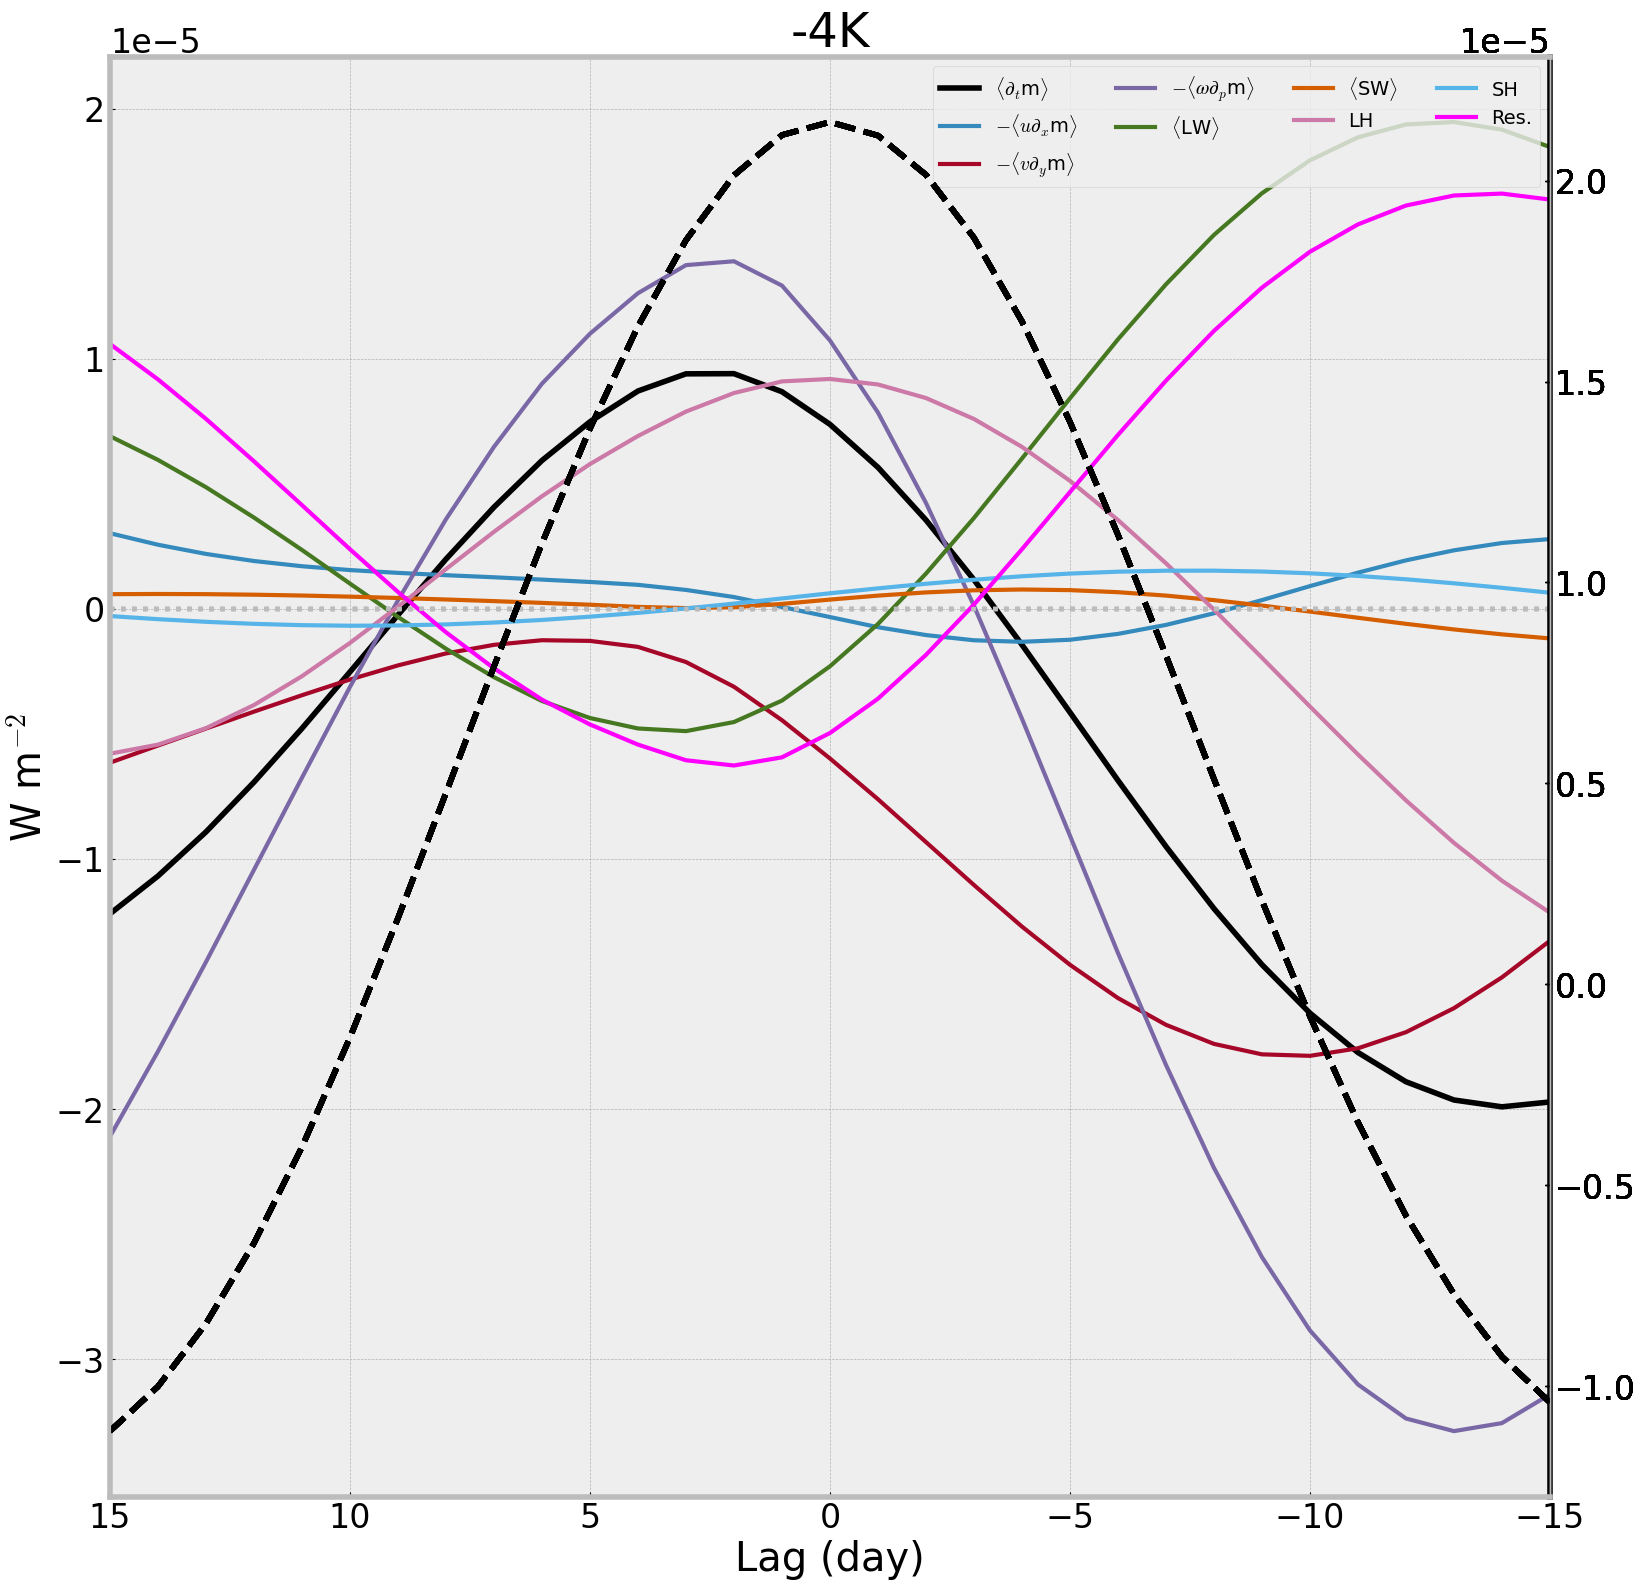

In [124]:
lines = {}

plt.style.use('bmh')
plt.rcParams.update({"font.size": 24})

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(1, 1, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.5, wspace=0.1)

# ax = []
ax = fig.add_subplot(gs[0])

for index, (variable_name, variable_data) in enumerate(variables_composited.data_vars.items()):
    if variable_name != 'Moist Static Energy':
        lines[index] = ax.plot(
            variable_data.day,
            variable_data.sel(lon=reference_lon, lat=meridional_mean_region).mean(dim='lat'),
            label=f"{variables_composited[variable_name].attrs['math_name']}",
            lw=(4 if variable_name == 'MSE Tendency' else 3),
            color=('k' if variable_name == 'MSE Tendency' else ('magenta' if variable_name == 'Residual' else bmh_colors(index-1)))
        )

    # fig.suptitle(
    #     f"MSE Budget Terms regressed on {reference_variable.attrs['math_name']} at {reference_lon}°",
    #     y=1.025
    # )

    ax.set_title(f"{experiment}")
    ax.invert_xaxis()
    ax.set_xlim(-num_composite_days//2, num_composite_days//2)
    # ax.set_xticks(np.arange(-15, 20, 2.5))

    ax.set_xlabel('Lag (day)')
    ax.set_ylabel(r'W m$^{-2}$')
    ax.axhline(y=0, color='#bcbcbc', ls=':', lw=3)

    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(4)
    ax.spines['right'].set_color('k')

    ax2 = ax.twinx()
    # ax2.plot(
    #     variables_composited['Moist Static Energy'].day,
    #     variables_composited['Moist Static Energy'].sel(lon=reference_lon, lat=meridional_mean_region).mean(dim='lat'),
    #     label=variables_composited['Moist Static Energy'].attrs['math_name'],
    #     color='k',
    #     ls='--',
    #     lw=4
    # )
    ax2.plot(
        precipitation_composited.day,
        precipitation_composited,
        label=precipitation_composited.attrs['math_name'],
        color='k',
        ls='--',
        lw=4
    )
    ax2.grid(False)
    ax2.invert_xaxis()
    ax.legend(fontsize=14, ncol=4, loc='upper right')

plt.show()

# EOF Analysis

In [344]:
# output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = False
calculate_eofs = True
plot_eofs = True

compositing_variable = precipitation_mjo_filtered#.resample(time='D').mean().copy(deep=True)
time = compositing_variable.time
latitude = compositing_variable.lat
longitude = compositing_variable.lon

EOF = xr.DataArray(
    data = np.empty((len(time), len(latitude), len(longitude))),
    dims=["index", "lat", "lon"],
    coords=dict(
        index=np.arange(len(time)),
        lat=latitude,
        lon=longitude
    )
)

PC = xr.DataArray(
    data = np.empty((len(time), len(time))),
    dims=["index", "time"],
    coords=dict(
        index=np.arange(len(time)),
        time=time
    )
)

eigenvalue_spectrum = xr.DataArray(
    data = np.empty((len(time))),
    dims=["index"],
    coords=dict(
        index=np.arange(len(time)),
    )
)

spectrum_error = xr.DataArray(
    data = np.empty((len(time))),
    dims=["index"],
    coords=dict(
        index=np.arange(len(time)),
    )
)

print(f"Variable: {compositing_variable.name}")

if calculate_eofs:

    print("Reshaping variables...")
    reshaped_variable = np.reshape(
        compositing_variable.values,
        (
            len(compositing_variable.time),
            (
                len(compositing_variable.lat)
                * len(compositing_variable.lon)
            ),
        ),
    )
    print("Variables reshaped")

    #### Calculate EOFs and PCs
    print("Computing EOFs...")
    U, S, VT = np.linalg.svd(reshaped_variable.T, full_matrices=False)
    EOF[:] = np.reshape(
                U.T,
                (
                    len(compositing_variable.time),
                    len(compositing_variable.lat),
                    len(compositing_variable.lon),
                ),
            )
    PC[:] = np.dot(np.diag(S), VT)
    print("EOFs computed")

    # Calculate nominal degrees of freedom
    nominal_degrees_of_freedom = np.size(reshaped_variable, 1)

    # Calculate eigenvalues and spectrum
    eigenvalues = S**2 / nominal_degrees_of_freedom
    eigenvalue_spectrum[:] = eigenvalues / np.sum(eigenvalues)
    explained_variance = 100 * eigenvalue_spectrum

    # Estimate 1-lag autocorrelation and effective degrees of freedom
    lag = 1
    B = 0
    for k in range(lag - 1, nominal_degrees_of_freedom - lag):
        B = B + np.sum(reshaped_variable[:, k] * reshaped_variable[:, k + lag])
    phi_L = 1 / (nominal_degrees_of_freedom - 2 * lag) * B
    phi_0 = 1 / nominal_degrees_of_freedom * np.sum(reshaped_variable**2)
    autocorrelation = phi_L / phi_0
    degrees_of_freedom = (
        (1 - autocorrelation**2) / (1 + autocorrelation**2)
    ) * nominal_degrees_of_freedom

    # Estimate uncertainty in eigenvalue spectrum
    spectrum_error[:] = (
        eigenvalue_spectrum
        * np.sqrt(2 / degrees_of_freedom)
    )

else:
    print("Using pre-calculated EOFs")

print(f"{'='*40}")
print("Finished")

Variable: Precipitation
Reshaping variables...
Variables reshaped
Computing EOFs...
EOFs computed
Finished


In [345]:
EOFs_to_use = 'horizontal'

print(f"Constructing RMM indices from {EOFs_to_use} PCs...")
if EOFs_to_use == 'horizontal':
    RMM1 = PC.sel(index=0) / PC.sel(index=0).std(dim='time')
    RMM2 = -PC.sel(index=1) / PC.sel(index=1).std(dim='time')
    RMM3 = PC.sel(index=2) / PC.sel(index=2).std(dim='time')
    RMM4 = -PC.sel(index=3) / PC.sel(index=3).std(dim='time')

mjo_strength_12 = np.sqrt(RMM1**2 + RMM2**2)
mjo_strength_34 = np.sqrt(RMM3**2 + RMM4**2)

# Remove weak MJO events
RMM1 = RMM1.where(mjo_strength_12 >= 1)
RMM2 = RMM2.where(mjo_strength_12 >= 1)
RMM3 = RMM3.where(mjo_strength_34 >= 1)
RMM4 = RMM4.where(mjo_strength_34 >= 1)

RMM1.attrs['EOF_type'] = EOFs_to_use
RMM2.attrs['EOF_type'] = EOFs_to_use
RMM3.attrs['EOF_type'] = EOFs_to_use
RMM4.attrs['EOF_type'] = EOFs_to_use

RMM1.attrs['EOF_vars'] = (compositing_variable.name if EOFs_to_use == 'horizontal' else 'OLR, U200, U850')
RMM2.attrs['EOF_vars'] = (compositing_variable.name if EOFs_to_use == 'horizontal' else 'OLR, U200, U850')
RMM3.attrs['EOF_vars'] = (compositing_variable.name if EOFs_to_use == 'horizontal' else 'OLR, U200, U850')
RMM4.attrs['EOF_vars'] = (compositing_variable.name if EOFs_to_use == 'horizontal' else 'OLR, U200, U850')

print("RMM indices constructed")

Constructing RMM indices from horizontal PCs...
RMM indices constructed


In [346]:
xr.set_options(keep_attrs=True)
print(f"{'Composite on MJO strength':^{str_width}}")
print(f"{'='*str_width}")

variables_mjo_composited = {}
for index, (variable_name, variable_data) in enumerate(variables_mjo_filtered.data_vars.items()):
    print(
        f"{f'({index+1}/{len(variables_mjo_filtered)}) {variable_name}...':<{str_width-1}}",
        end=""
    )

    variables_mjo_composited[variable_name] = variable_data.sel(
        time = mjo_strength_12.where(mjo_strength_12 <= 1).dropna('time').time
    ).mean(dim='time')
    print(rf"{'✔':>1}")

variables_mjo_composited = xr.merge([variable for variable in variables_mjo_composited.values()])

print(f"{'='*str_width}")
print("Finished")

       Composite on MJO strength        
(1/10) Moist Static Energy...          ✔
(2/10) MSE Tendency...                 ✔
(3/10) Zonal Advection...              ✔
(4/10) Meridional Advection...         ✔
(5/10) Vertical Advection...           ✔
(6/10) Longwave Heating...             ✔
(7/10) Shortwave Heating...            ✔
(8/10) Latent Heating...               ✔
(9/10) Sensible Heating...             ✔
(10/10) Residual...                    ✔
Finished


# Regress filtered variables onto MJO time series

In [87]:
xr.set_options(keep_attrs=True)
print(f"{'Regress variables':^{str_width}}")
print(f"{'='*str_width}")

regression_variable = f"MJO-filtered OLR"

if regression_variable == f"MJO-Filtered Precipiation":
    reference_timeseries = precipitation_mjo_filtered.resample(time='D').mean().sel(
        lon=reference_lon,
        lat=meridional_mean_region
    ).weighted(weights).mean(dim='lat')


elif regression_variable == f"PRCP-derived PCs":
    reference_timeseries = PC.isel(index=PC_index)

elif regression_variable == f"MJO-filtered OLR":
    reference_longitude = 180
    reference_latitude = outgoing_longwave_radiation_mjo_filtered.var(dim='time').mean(dim='lon').idxmax().values
    reference_timeseries = outgoing_longwave_radiation_mjo_filtered.sel(lat=reference_latitude, lon=reference_longitude)

# Normalize the reference precipitation time series
reference_timeseries = reference_timeseries.drop_sel(time=missing_timesteps, errors='ignore')
# standardized_reference_timeseries = (
#     reference_timeseries - reference_timeseries.mean(dim='time')
#     ) / reference_timeseries.std(dim='time')
standardized_reference_timeseries = standardize_data(reference_timeseries, unit_variance=True, dim='time')

N = len(standardized_reference_timeseries)
t_critical = t.ppf(0.95, df=N-2)

print(
    f"{f'Outgoing Longwave Radiation...':<{str_width-1}}",
    end=""
)
outgoing_longwave_radiaton_anomaly = (
    outgoing_longwave_radiation_subset
    - outgoing_longwave_radiation_subset.mean(dim='time')
)
outgoing_longwave_radiation_regressed = xr.zeros_like(outgoing_longwave_radiation.isel(time=0, drop=True))
outgoing_longwave_radiation_regressed[:] = np.einsum(
        'i,i...->...',
        standardized_reference_timeseries,
        outgoing_longwave_radiaton_anomaly
    ) / len(standardized_reference_timeseries)

predicted_value = outgoing_longwave_radiation_regressed * standardized_reference_timeseries
residual_sum_of_squares = ((outgoing_longwave_radiaton_anomaly - predicted_value) ** 2).sum(dim='time')
residual_variance = residual_sum_of_squares / (N - 2)

# Calculate standard error of the slope
standard_error_slope = np.sqrt(residual_variance / (N - 1))

# Compute t-statistic
t_statistic = outgoing_longwave_radiation_regressed / standard_error_slope

olr_significant_indices = np.abs(t_statistic) > t_critical
print(rf"{'✔':>1}")

# Budget variables
budget_variables_regressed = {}
significant_indices = {}

print(f"{'Non-Budget Variables':^{str_width}}")
for index, (variable_name, variable_data) in enumerate(budget_variables_subset.data_vars.items()):
    print(
        f"{f'({index+1}/{len(budget_variables_subset.data_vars.items())}) {variable_name}...':<{str_width-1}}",
        end=""
    )
    reference_variable = variable_data.drop_sel(time=missing_timesteps, errors='ignore')
    reference_variable_anomaly = standardize(reference_variable, unit_variance=False, dim='time')
    budget_variables_regressed[variable_name] = xr.zeros_like(reference_variable.isel(time=0).drop_vars('time'))
    budget_variables_regressed[variable_name][:] = np.einsum(
        'i,i...->...',
        standardized_reference_timeseries,
        reference_variable_anomaly
    ) / len(standardized_reference_timeseries)

    predicted_value = budget_variables_regressed[variable_name] * standardized_reference_timeseries
    residual_sum_of_squares = ((reference_variable_anomaly - predicted_value) ** 2).sum(dim='time')
    residual_variance = residual_sum_of_squares / (N - 2)

    # Calculate standard error of the slope
    standard_error_slope = np.sqrt(residual_variance / (N - 1))

    # Compute t-statistic
    t_statistic = budget_variables_regressed[variable_name] / standard_error_slope

    significant_indices[variable_name] = np.abs(t_statistic) > t_critical
    print(rf"{'✔':>1}")

budget_variables_regressed = xr.merge([variable for variable in budget_variables_regressed.values()])
budget_variables_regressed.attrs['name'] = f"Variables regressed on {regression_variable}"

# # Non-Budget Variables
# non_budget_variables_regressed = {}
# non_budget_reference_variable_anomaly = {}

# print(f"{'='*str_width}")
# print(f"{'Non-Budget Variables':^{str_width}}")
# print(f"{'='*str_width}")
# # for index, (variable_name, variable_data) in enumerate(non_budget_variables_subset.data_vars.items()):
# for index, (variable_name, variable_data) in enumerate(non_budget_variables_subset.data_vars.items()):
#     print(
#         f"{f'({index+1}/{len(non_budget_variables_subset.data_vars.items())}) {variable_name}...':<{str_width-1}}",
#         end=""
#     )
#     reference_variable = variable_data.drop_sel(time=missing_days, errors='ignore')
#     reference_variable_anomaly = reference_variable - reference_variable.mean(dim='time')
#     non_budget_variables_regressed[variable_name] = xr.zeros_like(reference_variable.isel(time=0).drop_vars('time'))
#     non_budget_variables_regressed[variable_name][:] = np.einsum(
#         'i,i...->...',
#         standardized_reference_timeseries,
#         reference_variable_anomaly
#     ) / len(standardized_reference_timeseries)

#     predicted_value = non_budget_variables_regressed[variable_name] * standardized_reference_timeseries
#     residual_sum_of_squares = ((reference_variable_anomaly - predicted_value) ** 2).sum(dim='time')
#     residual_variance = residual_sum_of_squares / (N - 2)

#     # Calculate standard error of the slope
#     standard_error_slope = np.sqrt(residual_variance / (N - 1))

#     # Compute t-statistic
#     t_statistic = non_budget_variables_regressed[variable_name] / standard_error_slope

#     significant_indices[variable_name] = np.abs(t_statistic) > t_critical
#     print(rf"{'✔':>1}")

# non_budget_variables_regressed = xr.merge([variable for variable in non_budget_variables_regressed.values()])
# non_budget_variables_regressed.attrs['name'] = f"Variables regressed on {regression_variable}"

# Re-scale fields to have a maximum OLR anomaly of -40 W m^-2 at the reference location
scaled_budget_variables_regressed = (
    -40 * budget_variables_regressed
    / outgoing_longwave_radiation_regressed.sel(lat=reference_latitude, lon=reference_longitude)
)

# scaled_non_budget_variables_regressed = (
#     -40 * non_budget_variables_regressed
#     / non_budget_variables_regressed['Outgoing Longwave Radiation'].sel(lat=reference_latitude, lon=reference_longitude)
# )

print(f"{'='*str_width}")
print("Finished")

           Regress variables            
          Non-Budget Variables          
(1/10) Moist Static Energy...          ✔
(2/10) MSE Tendency...                 ✔
(3/10) Zonal Advection...              ✔
(4/10) Meridional Advection...         ✔
(5/10) Vertical Advection...           ✔
(6/10) Longwave Heating...             ✔
(7/10) Shortwave Heating...            ✔
(8/10) Latent Heating...               ✔
(9/10) Sensible Heating...             ✔
(10/10) Residual...                    ✔
Finished


In [89]:
scaled_budget_variables_regressed = (
    -40 * budget_variables_regressed
    / outgoing_longwave_radiation_regressed.sel(lat=reference_latitude, lon=reference_longitude)
)


In [83]:
# standardized_reference_timeseries
scaled_budget_variables_regressed

<xarray.Dataset> Size: 10GB
Dimensions:               (lat: 32, lon: 144, time: 29406)
Coordinates:
  * lat                   (lat) float64 256B -29.37 -27.47 ... 27.47 29.37
  * lon                   (lon) float64 1kB 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                  (time) object 235kB 0003-01-03 09:00:00 ... 0013-02...
Data variables:
    Moist Static Energy   (lat, lon, time) float64 1GB 2.08e+06 ... -4.567e+06
    MSE Tendency          (lat, lon, time) float64 1GB 0.9469 1.383 ... 6.79
    Zonal Advection       (lat, lon, time) float64 1GB 29.29 42.77 ... -135.4
    Meridional Advection  (lat, lon, time) float64 1GB -31.32 -45.73 ... -16.92
    Vertical Advection    (lat, lon, time) float64 1GB 4.383 6.4 ... -253.8 89.4
    Longwave Heating      (lat, lon, time) float64 1GB 0.7806 1.14 ... 3.77
    Shortwave Heating     (lat, lon, time) float64 1GB -0.08664 ... -0.04895
    Latent Heating        (lat, lon, time) float32 542MB -2.573 -3.757 ... 13.3
    Sensible Heating      (lat, lon, time) float32 542MB -0.1655 ... 7.558
    Residual              (lat, lon, time) float64 1GB 0.6412 0.9363 ... 45.1
Attributes:
    long_name:  Frozen Moist Static Energy
    math_name:  $\langle$m$\rangle$
    units:      J m$^{-2}$
    name:       Variables regressed on MJO-filtered OLR

In [76]:
scaled_budget_variables_regressed = (
    -40 * budget_variables_regressed
    / outgoing_longwave_radiation_mjo_filtered.sel(lat=reference_latitude, lon=reference_longitude)
)

## Plot OLR-PRCP-CWV

Saving plot as 0K_OLR-PRCP-CWV_plot.png


/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/matplotlib/quiver.py:630: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/glade/u/apps/opt/conda/envs/npl-2024b/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved
Finished


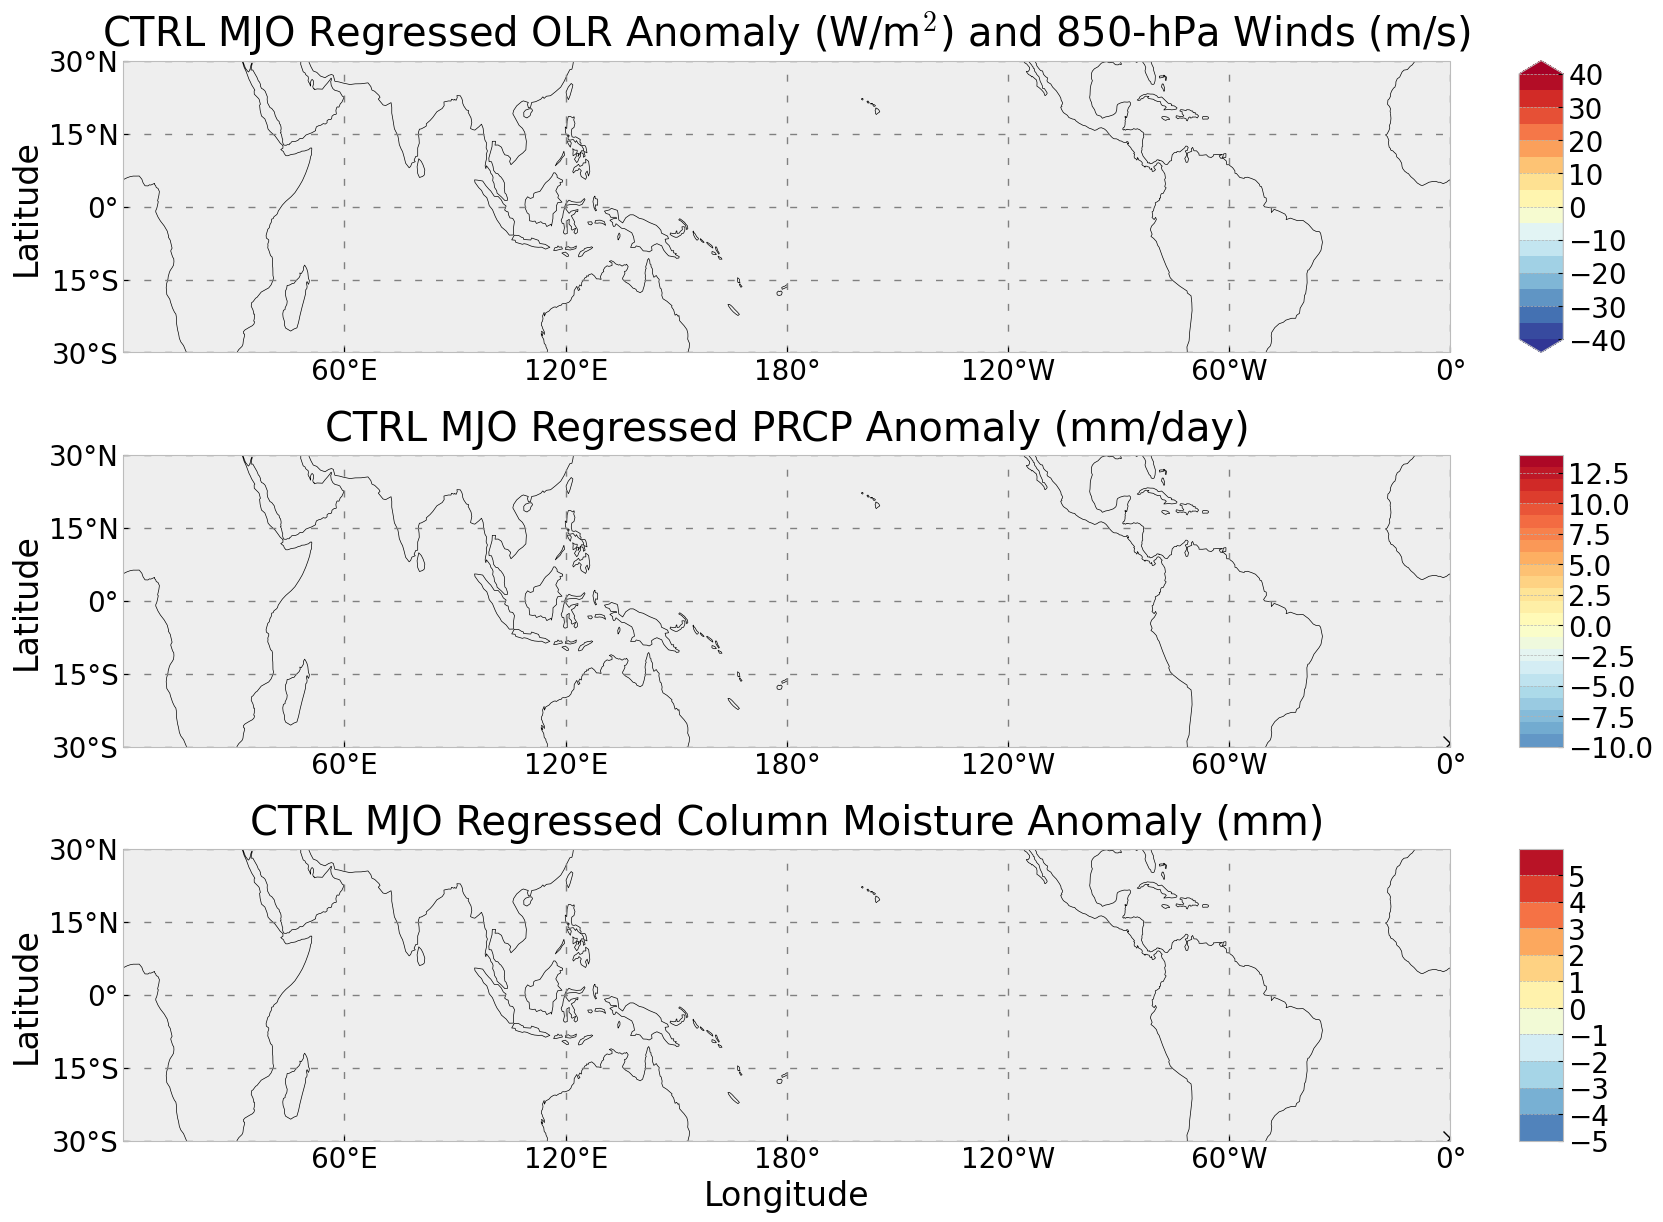

In [216]:
savefig = False
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
colormap = 'RdYlBu_r'

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 2, width_ratios=[30,1], height_ratios=[1,1,1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35, wspace=0.1)

axes = []
axes.append(fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=180)))

cbar_axes = []
cbar_axes.append(fig.add_subplot(gs[0,1]))
cbar_axes.append(fig.add_subplot(gs[1,1]))
cbar_axes.append(fig.add_subplot(gs[2,1]))

# Outgoing Longwave Radiation
axes[0].set_title(rf"{experiment_shortname} MJO Regressed OLR Anomaly (W/m$^{2}$) and 850-hPa Winds (m/s)", pad=10)

[cOLR, clon] = cutil.add_cyclic_point(
    scaled_non_budget_variables_regressed['Outgoing Longwave Radiation'].where(significant_indices_indices['Outgoing Longwave Radiation']),
    scaled_non_budget_variables_regressed['Outgoing Longwave Radiation'].lon
)

im0 = axes[0].contourf(
    clon,
    scaled_non_budget_variables_regressed['Outgoing Longwave Radiation'].lat,
    cOLR,
    levels=np.arange(-40, 45, 5),
    cmap=colormap,
    norm=mcolors.CenteredNorm(vcenter=0),
    extend='both',
    transform=ccrs.PlateCarree()
)
cbar0 = fig.colorbar(im0, cax=cbar_axes[0])
cbar0.set_ticks(np.arange(-40, 50, 10))

[cU, clon] = cutil.add_cyclic_point(
    scaled_non_budget_variables_regressed['Zonal Wind'].where(significant_indices['Zonal Wind']).sel(plev=850),
    scaled_non_budget_variables_regressed['Zonal Wind'].lon
)
[cV, clon] = cutil.add_cyclic_point(
    scaled_non_budget_variables_regressed['Meridional Wind'].where(significant_indices['Meridional Wind']).sel(plev=850),
    scaled_non_budget_variables_regressed['Meridional Wind'].lon
)

axes[0].quiver(
    clon[::3],
    scaled_non_budget_variables_regressed['Zonal Wind'].lat[::3],
    cU[::3, ::3],
    cV[::3, ::3],
    width=0.00125,
    transform=ccrs.PlateCarree()
)

[cPRCP, clon] = cutil.add_cyclic_point(
    scaled_non_budget_variables_regressed['Precipitation'].where(significant_indices['Precipitation']),
    scaled_non_budget_variables_regressed['Precipitation'].lon
)

# Precipitation
axes[1].set_title(rf"{experiment_shortname} MJO Regressed PRCP Anomaly (mm/day)", pad=10)
im1 = axes[1].contourf(
    clon,
    scaled_non_budget_variables_regressed['Precipitation'].lat,
    cPRCP,
    levels=np.arange(-10, 15, 1),
    cmap=colormap,
    norm=mcolors.CenteredNorm(vcenter=0),
    transform=ccrs.PlateCarree()
)
cbar1 = fig.colorbar(im1, cax=cbar_axes[1])
cbar1.set_ticks(np.arange(-10, 15, 2.5))
axes[1].plot(reference_longitude, reference_latitude, marker='x', color='black', ms=10)

# Column moisture
[cCWV, clon] = cutil.add_cyclic_point(
    scaled_non_budget_variables_regressed['Column Moisture'].where(significant_indices['Column Moisture']),
    scaled_non_budget_variables_regressed['Column Moisture'].lon
)

axes[2].set_title(rf"{experiment_shortname} MJO Regressed Column Moisture Anomaly (mm)", pad=10)
im2 = axes[2].contourf(
    clon,
    scaled_non_budget_variables_regressed['Column Moisture'].lat,
    cCWV,
    levels=np.arange(-5, 7, 1),
    cmap=colormap,
    norm=mcolors.CenteredNorm(vcenter=0),
    transform=ccrs.PlateCarree()
)
cbar2 = fig.colorbar(im2, cax=cbar_axes[2])
cbar2.set_ticks(np.arange(-5, 6, 1))
axes[2].plot(reference_longitude, reference_latitude, marker='x', color='black', ms=10)


# Axis parameters
# for ax in axes:

#     ax.plot(reference_longitude, reference_latitude, marker='x', color='black', ms=12)

#     ax.set_aspect("equal")

#     ax.set_xlim(0, 360)
#     x_ticks = np.arange(0, 360 + 60, 60)
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels(tick_labeller(x_ticks-180, "lon"))
#     ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))
#     ax.set_xlabel("Longitude")

#     ax.set_ylim(-30, 30)
#     y_ticks = np.arange(-30, 45, 15)
#     ax.set_yticks(y_ticks)
#     ax.set_yticklabels(tick_labeller(y_ticks, "lat"))
#     ax.set_ylabel("Latitude")

#     grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
#     ax.grid(True, **grid_kwargs)

for index, ax in enumerate(axes):

    ax.set_aspect("auto")
    ax.add_feature(cf.COASTLINE)
    ax.set_xlim(-180, 180)
    # x_ticks = np.arange(0, 360 + 60, 60)
    x_ticks = np.arange(-180, 180 + 60, 60)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(tick_labeller(x_ticks+180, "lon"))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

    if index == len(axes)-1:
        ax.set_xlabel("Longitude")

    ax.set_ylim(-30, 30)
    y_ticks = np.arange(-30, 45, 15)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(tick_labeller(y_ticks, "lat"))
    ax.set_ylabel("Latitude")

    grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
    ax.grid(True, **grid_kwargs)

if not savefig:
    plt.show()
else:
    save_string = f"{experiment}_OLR-PRCP-CWV_plot.png"
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/Andersen_Kuang_plots/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )
    print("Saved")

print("Finished")

## Plot MSE-dMSEdT-RES

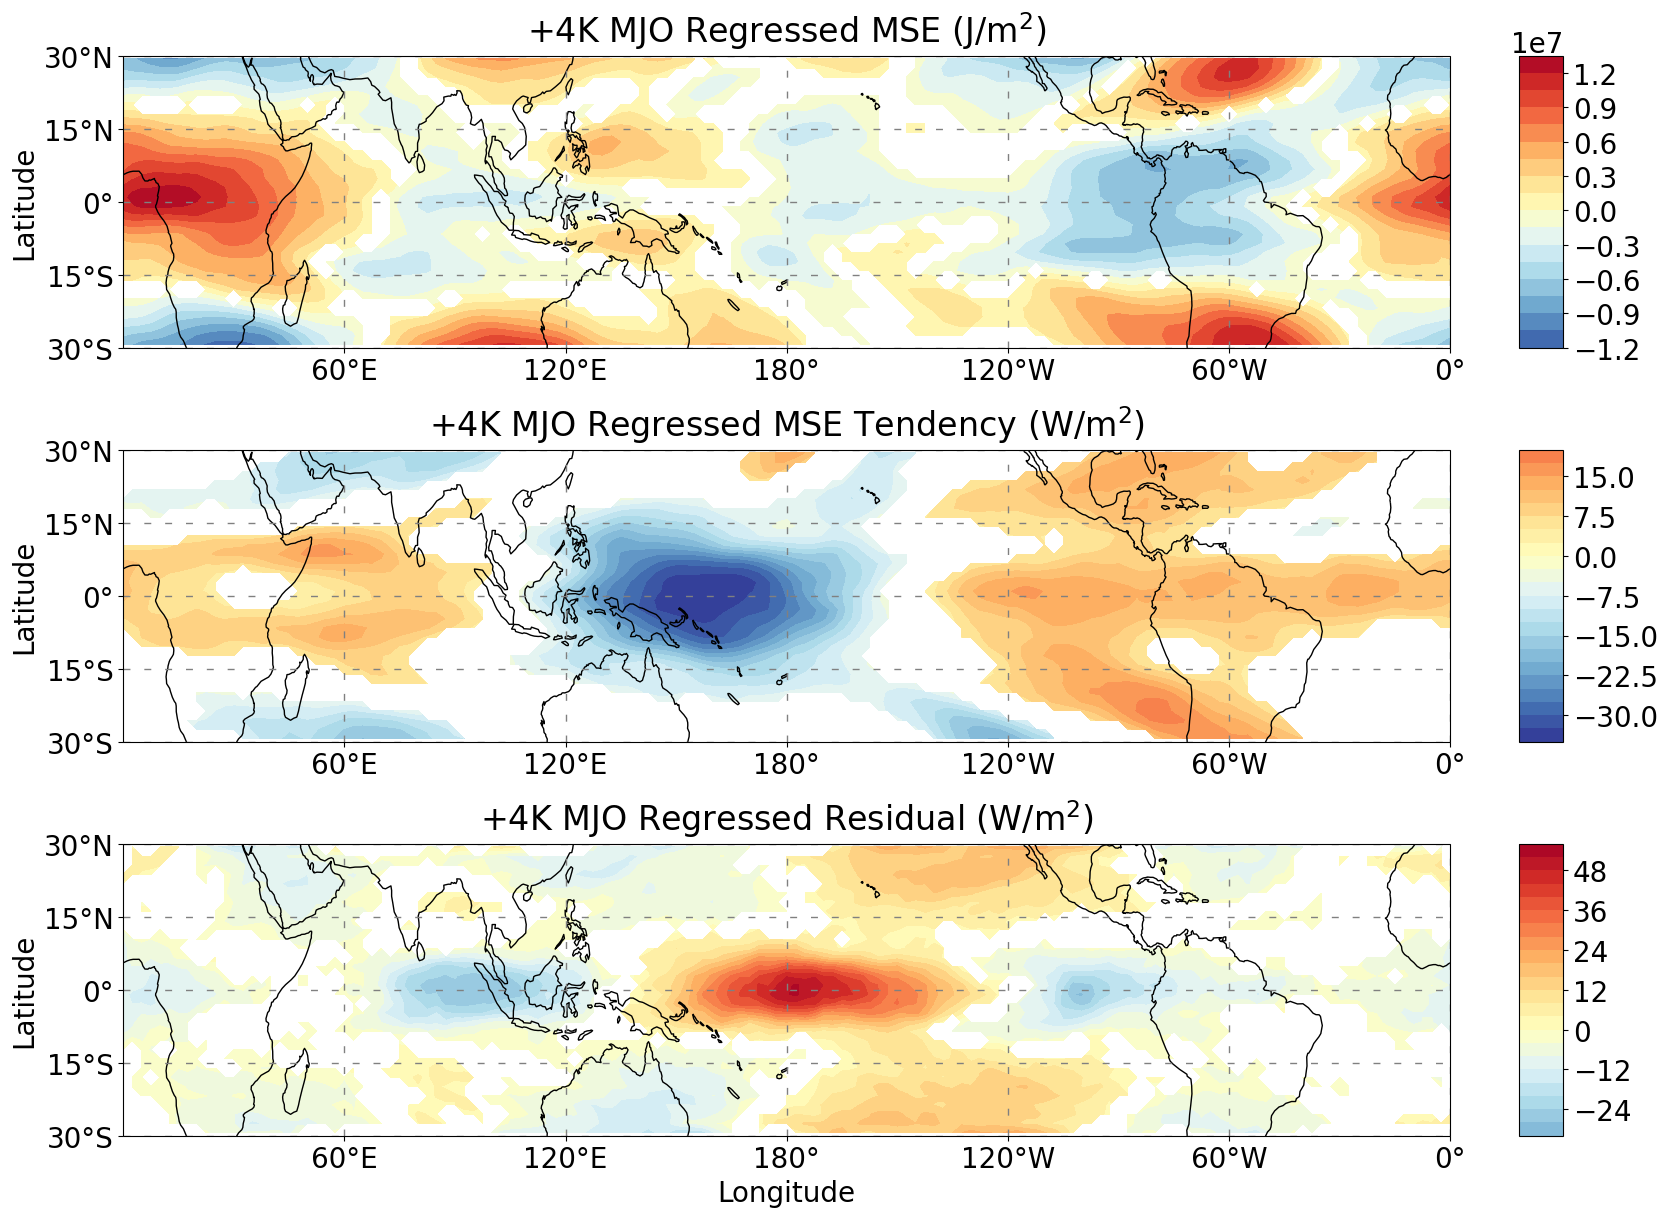

Finished


In [90]:
savefig = False
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
colormap = 'RdYlBu_r'

plt.style.use('default')
plt.rcParams.update({'font.size':20})

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(3, 2, width_ratios=[30,1], height_ratios=[1,1,1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.35, wspace=0.1)

axes = []
axes.append(fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=180)))

cbar_axes = []
cbar_axes.append(fig.add_subplot(gs[0,1]))
cbar_axes.append(fig.add_subplot(gs[1,1]))
cbar_axes.append(fig.add_subplot(gs[2,1]))

axes[0].set_title(f"{experiment_shortname} MJO Regressed MSE (J/m$^{2}$)", pad=10)
[cMSE, clon] = cutil.add_cyclic_point(
    scaled_budget_variables_regressed['Moist Static Energy'].where(significant_indices['Moist Static Energy']),
    scaled_budget_variables_regressed['Moist Static Energy'].lon
)

im = axes[0].contourf(
    clon,
    scaled_budget_variables_regressed['Moist Static Energy'].lat,
    cMSE,
    levels=21,
    cmap=colormap,
    norm=mcolors.CenteredNorm(vcenter=0)
)
fig.colorbar(im, cax=cbar_axes[0])

# [cU, clon] = cutil.add_cyclic_point(
#     scaled_non_budget_variables_regressed['Zonal Wind'].where(significant_indices['Zonal Wind']).sel(plev=850),
#     scaled_non_budget_variables_regressed['Zonal Wind'].lon
# )
# [cV, clon] = cutil.add_cyclic_point(
#     scaled_non_budget_variables_regressed['Meridional Wind'].where(significant_indices['Meridional Wind']).sel(plev=850),
#     scaled_non_budget_variables_regressed['Meridional Wind'].lon
# )

# axes[0].quiver(
#     clon[::3],
#     scaled_non_budget_variables_regressed['Zonal Wind'].lat[::3],
#     cU[::3, ::3],
#     cV[::3, ::3]
#     # cmap='coolwarm'
# )

axes[1].set_title(f"{experiment_shortname} MJO Regressed MSE Tendency (W/m$^{2}$)", pad=10)
[cMSE, clon] = cutil.add_cyclic_point(
    scaled_budget_variables_regressed['MSE Tendency'].where(significant_indices['MSE Tendency']),
    scaled_budget_variables_regressed['MSE Tendency'].lon
)

im = axes[1].contourf(
    clon,
    scaled_budget_variables_regressed['MSE Tendency'].lat,
    cMSE,
    levels=21,
    cmap=colormap,
    norm=mcolors.CenteredNorm(vcenter=0),
    transform=ccrs.PlateCarree()
)
fig.colorbar(im, cax=cbar_axes[1])

axes[2].set_title(f"{experiment_shortname} MJO Regressed Residual (W/m$^{2}$)", pad=10)
[cMSE, clon] = cutil.add_cyclic_point(
    scaled_budget_variables_regressed['Residual'].where(significant_indices['Residual']),
    scaled_budget_variables_regressed['Residual'].lon
)

im = axes[2].contourf(
    clon,
    scaled_budget_variables_regressed['Residual'].lat,
    cMSE,
    levels=21,
    cmap=colormap,
    norm=mcolors.CenteredNorm(vcenter=0),
    transform=ccrs.PlateCarree()
)
fig.colorbar(im, cax=cbar_axes[2])



# for ax in axes:
#     ax.plot(reference_longitude, reference_latitude, marker='x', color='black', ms=10)
#     ax.set_aspect("equal")

#     ax.set_xlim(0, 360)
#     x_ticks = np.arange(0, 360 + 60, 60)
#     ax.set_xticks(x_ticks)
#     ax.set_xticklabels(tick_labeller(x_ticks-180, "lon"))
#     ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))
#     ax.set_xlabel("Longitude")

#     ax.set_ylim(-30, 30)
#     y_ticks = np.arange(-30, 45, 15)
#     ax.set_yticks(y_ticks)
#     ax.set_yticklabels(tick_labeller(y_ticks, "lat"))
#     ax.set_ylabel("Latitude")

#     grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
#     ax.grid(True, **grid_kwargs)

for index, ax in enumerate(axes):

    ax.set_aspect("auto")
    ax.add_feature(cf.COASTLINE)
    ax.set_xlim(-180, 180)
    # x_ticks = np.arange(0, 360 + 60, 60)
    x_ticks = np.arange(-180, 180 + 60, 60)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(tick_labeller(x_ticks+180, "lon"))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

    if index == len(axes)-1:
        ax.set_xlabel("Longitude")

    ax.set_ylim(-30, 30)
    y_ticks = np.arange(-30, 45, 15)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(tick_labeller(y_ticks, "lat"))
    ax.set_ylabel("Latitude")

    grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
    ax.grid(True, **grid_kwargs)

if not savefig:
    plt.show()
else:
    save_string = f"{experiment}_MSE-dMSEdt-RES_plot.png"
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/Andersen_Kuang_plots/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )
    print("Saved")

print("Finished")

## Zonal Wind Anomaly

Saving plot as -4K_lat-height_zonal-wind-anomaly.png
Saved


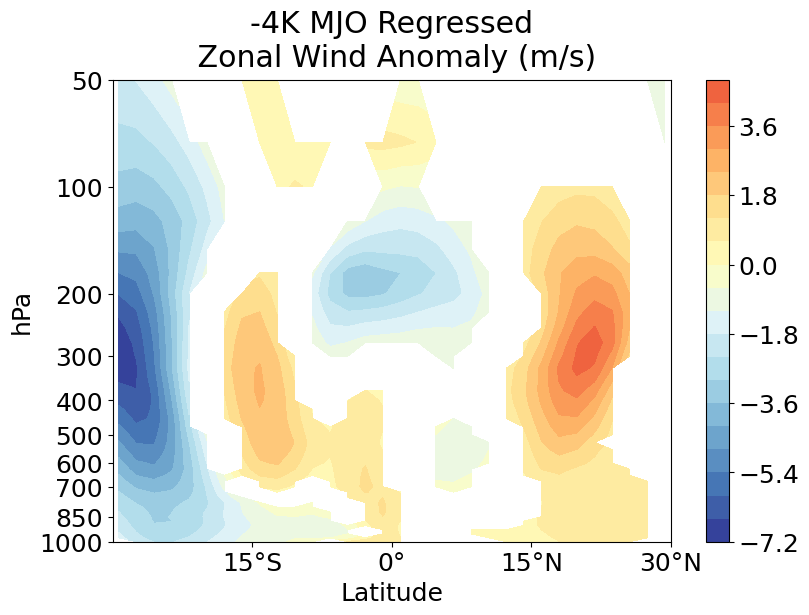

In [142]:
savefig = True
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"

plt.style.use('default')
plt.rcParams.update({'font.size':18})

[fig, ax] = plt.subplots(1, 1, figsize=(9,6))
ax.set_title(f"{experiment_shortname} MJO Regressed\n Zonal Wind Anomaly (m/s)", pad=10)
im = ax.contourf(
    scaled_non_budget_variables_regressed['Zonal Wind'].lat,
    np.log10(scaled_non_budget_variables_regressed['Zonal Wind'].plev),
    scaled_non_budget_variables_regressed['Zonal Wind'].where(significant_indices['Zonal Wind']).sel(lon=reference_longitude).T,
    cmap=colormap,
    norm=mcolors.CenteredNorm(vcenter=0),
    levels=21
)
fig.colorbar(im)

ax.set_aspect('auto')
ax.set_xlim(-30, 30)
x_ticks = np.arange(-30, 45, 15)
ax.set_xticks(x_ticks)
ax.set_xticklabels(tick_labeller(x_ticks, "lat"))
ax.xaxis.set_major_locator(mticker.MaxNLocator(5, prune="lower"))
ax.set_xlabel('Latitude')


ax.set_ylim(np.log10(50), np.log10(1000))
ax.set_yticks(np.log10([1000, 850, 700, 600, 500, 400, 300, 200, 100, 50]), labels=[1000, 850, 700, 600, 500, 400, 300, 200, 100, 50])

ax.invert_yaxis()
# ax.set_yscale('log')
# ax.set_yticks([], labels='')
ax.set_ylabel('hPa')

if not savefig:
    plt.show()
else:
    save_string = f"{experiment}_lat-height_zonal-wind-anomaly.png"
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/Andersen_Kuang_plots/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )
    print("Saved")

## Plot Budget terms regressed

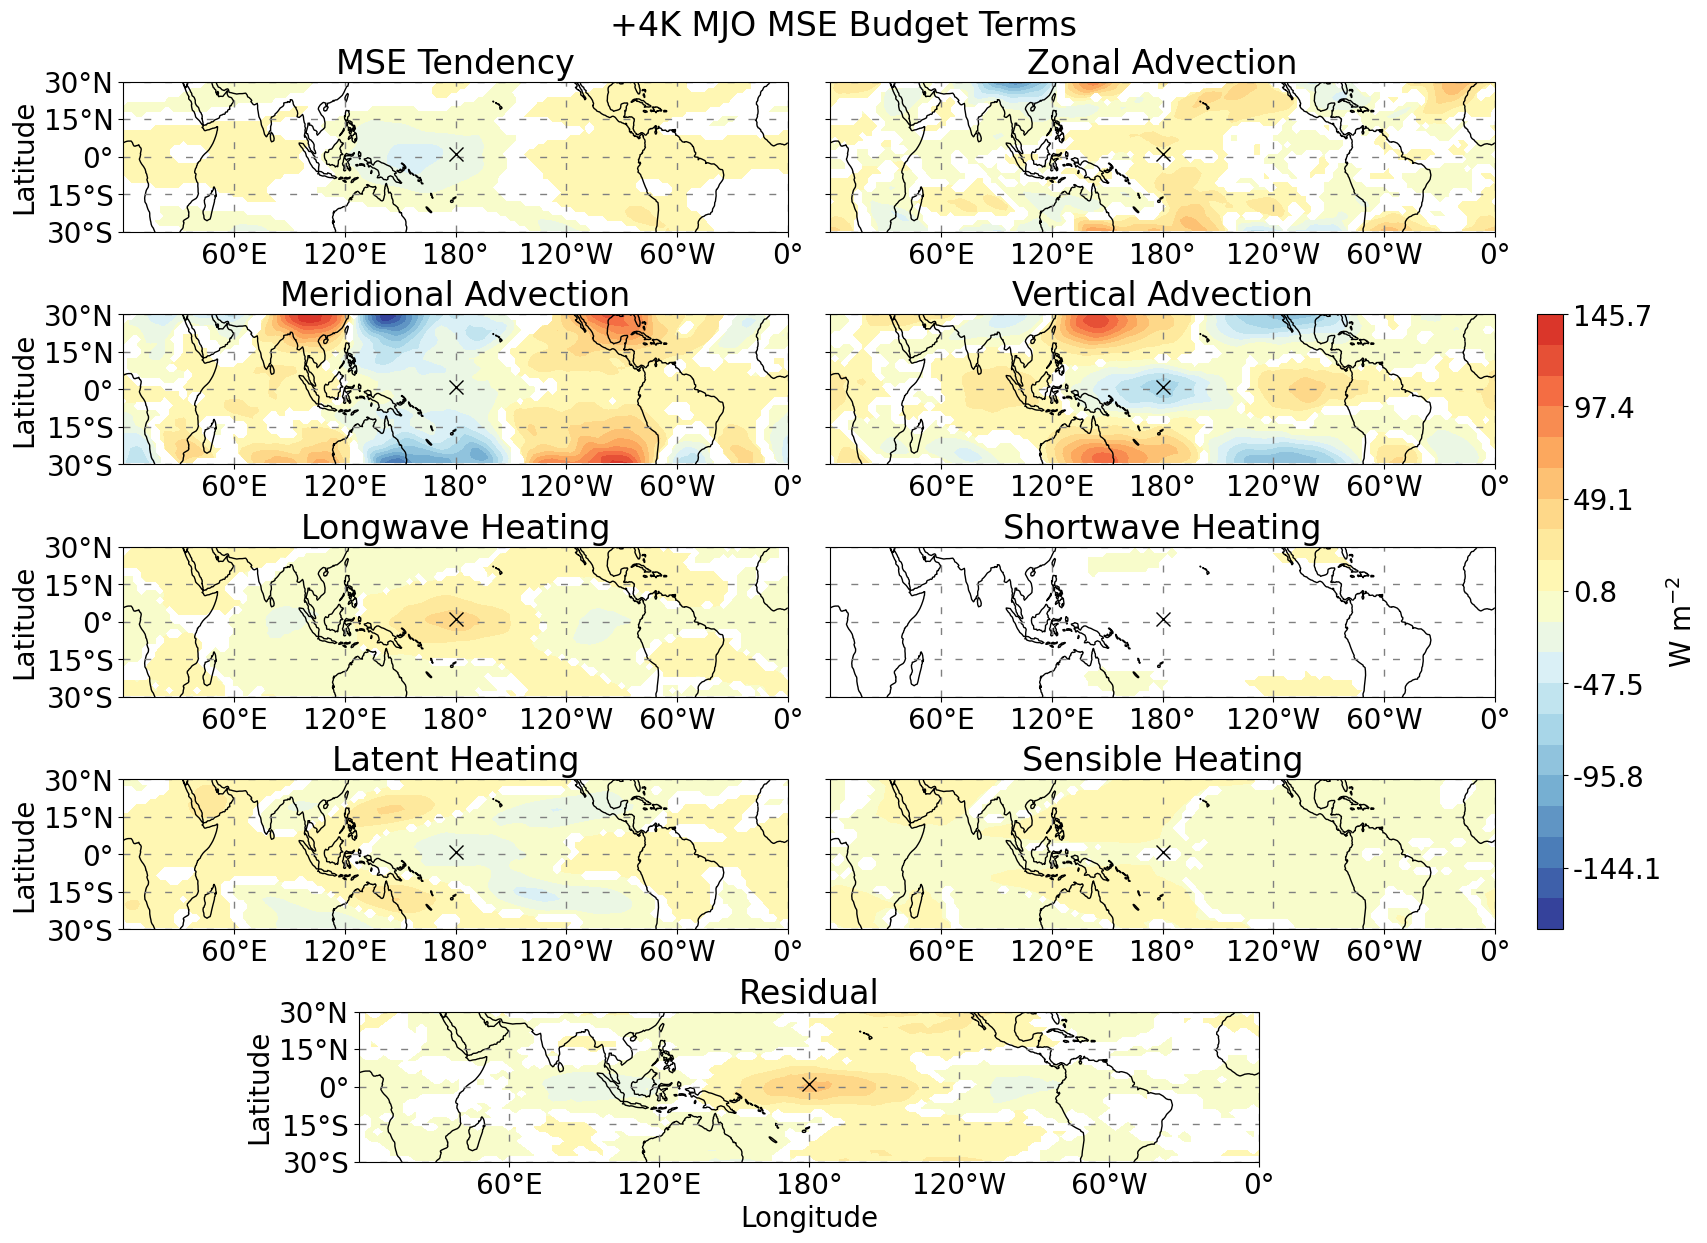

In [91]:
savefig=False
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"

plt.style.use('default')
plt.rcParams.update({'font.size':20})

meridional_mean_region = slice(-50,50)
colormap = 'RdYlBu_r'

fig = plt.figure(figsize=(16, 12))
gs = GridSpec(5, 7, width_ratios=[15,15,15,15,15,15,2], height_ratios=[1,1,1,1,1], figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.55, wspace=0.25)

axes = []
axes.append(fig.add_subplot(gs[0, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[0, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[1, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[2, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[3, 0:3], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[3, 3:6], projection=ccrs.PlateCarree(central_longitude=180)))
axes.append(fig.add_subplot(gs[4, 1:5], projection=ccrs.PlateCarree(central_longitude=180)))

cbar_ax = fig.add_subplot(gs[1:-1,-1])

grand_max = scaled_budget_variables_regressed.where(significant_indices[variable_name]).sel(lat=meridional_mean_region).drop_vars('Moist Static Energy').to_array().max()
grand_min = scaled_budget_variables_regressed.where(significant_indices[variable_name]).sel(lat=meridional_mean_region).drop_vars('Moist Static Energy').to_array().min()

fig.suptitle(f"{experiment_shortname} MJO MSE Budget Terms", x=0.5, y=1.01)

for ax, (variable_name, variable_data) in zip(axes, list(scaled_budget_variables_regressed.data_vars.items())[1:]):
    [cdata, clon] = cutil.add_cyclic_point(
        variable_data.sel(lat=meridional_mean_region).where(significant_indices[variable_name]),
        variable_data.lon
    )

    ax.set_title(f"{variable_data.name}")
    im = ax.contourf(
        clon,
        variable_data.lat.sel(lat=meridional_mean_region),
        cdata,
        cmap=colormap,
        levels=np.linspace(grand_min, grand_max, 21),
        norm=mcolors.CenteredNorm(vcenter=0),
        transform=ccrs.PlateCarree()
    )
    ax.plot(
        reference_longitude,
        reference_latitude,
        transform=ccrs.PlateCarree(),
        marker='x',
        color='black',
        ms=10
    )

for index, ax in enumerate(axes):

    ax.set_aspect("auto")
    ax.add_feature(cf.COASTLINE)
    ax.set_xlim(-180, 180)
    # x_ticks = np.arange(0, 360 + 60, 60)
    x_ticks = np.arange(-180, 180 + 60, 60)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(tick_labeller(x_ticks+180, "lon"))
    ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))

    # if index == len(axes)-3 or index == len(axes)-2 or index == len(axes)-1:
    #     ax.set_xticklabels(tick_labeller(x_ticks+180, "lon"))
    #     ax.xaxis.set_major_locator(mticker.MaxNLocator(7, prune="lower"))
    # else:
    #     ax.set_xticklabels('')

    if index == len(axes)-1:
        ax.set_xlabel("Longitude")

    ax.set_ylim(-30, 30)
    y_ticks = np.arange(-30, 45, 15)
    # ax.set_ylim(-15, 15)
    # y_ticks = np.arange(-15, 15+7.5, 7.5)
    ax.set_yticks(y_ticks)
    if index%2 == 0:
        ax.set_yticklabels(tick_labeller(y_ticks, "lat"))
        ax.set_ylabel("Latitude")
    else:
        ax.set_yticklabels('')

    grid_kwargs = {"linewidth": 1, "linestyle": (0, (5, 10)), "color": "gray"}
    ax.grid(True, **grid_kwargs)

cbar = fig.colorbar(im, cax=cbar_ax, format='%.1f')
cbar.set_label(r"W m$^{-2}$")

if not savefig:
    plt.show()
else:
    save_string = f"{experiment}_budget_terms_latlon.png"
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/Andersen_Kuang_plots/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )
    print("Saved")

# Calculate maintenance contribution

In [92]:
composite_day = 0
zonal_mean_region = slice(0,360)
meridional_mean_region = slice(-10,10)

xr.set_options(keep_attrs=True)
print(f"{'Budget Maintenance Contribution':^{str_width}}")
print(f"{'='*str_width}")

# analysis_variables = variables_composited.sel(day=0)
# analysis_variables = variables_mjo_composited
analysis_variables = scaled_budget_variables_regressed
# analysis_variables = variables_mjo_filtered.isel(time=slice(100,110)).mean(dim='time')

budget_maintenance_contribution = {}
for index, (variable_name, variable_data) in enumerate(analysis_variables.data_vars.items()):
    print(
        f"{f'({index+1}/{len(analysis_variables)}) {variable_name}...':<{str_width-1}}",
        end=""
    )

    numerator = variable_data*analysis_variables['Moist Static Energy']
    denominator = analysis_variables['Moist Static Energy']*analysis_variables['Moist Static Energy']

    budget_maintenance_contribution[variable_name] = (
        numerator.sel(lat=meridional_mean_region).integrate(coord='lat').sel(lon=zonal_mean_region).integrate(coord='lon')
        / denominator.sel(lat=meridional_mean_region).integrate(coord='lat').sel(lon=zonal_mean_region).integrate(coord='lon')
    )
    budget_maintenance_contribution[variable_name].name = variable_data.name
    budget_maintenance_contribution[variable_name].attrs['math_name'] = variable_data.attrs['math_name']
    print(rf"{'✔':>1}")

budget_maintenance_contribution = xr.merge([variable for variable in budget_maintenance_contribution.values()])

print(f"{'='*str_width}")
print("Finished")

    Budget Maintenance Contribution     
(1/10) Moist Static Energy...          ✔
(2/10) MSE Tendency...                 ✔
(3/10) Zonal Advection...              ✔
(4/10) Meridional Advection...         ✔
(5/10) Vertical Advection...           ✔
(6/10) Longwave Heating...             ✔
(7/10) Shortwave Heating...            ✔
(8/10) Latent Heating...               ✔
(9/10) Sensible Heating...             ✔
(10/10) Residual...                    ✔
Finished


## Plot maintenance contribution

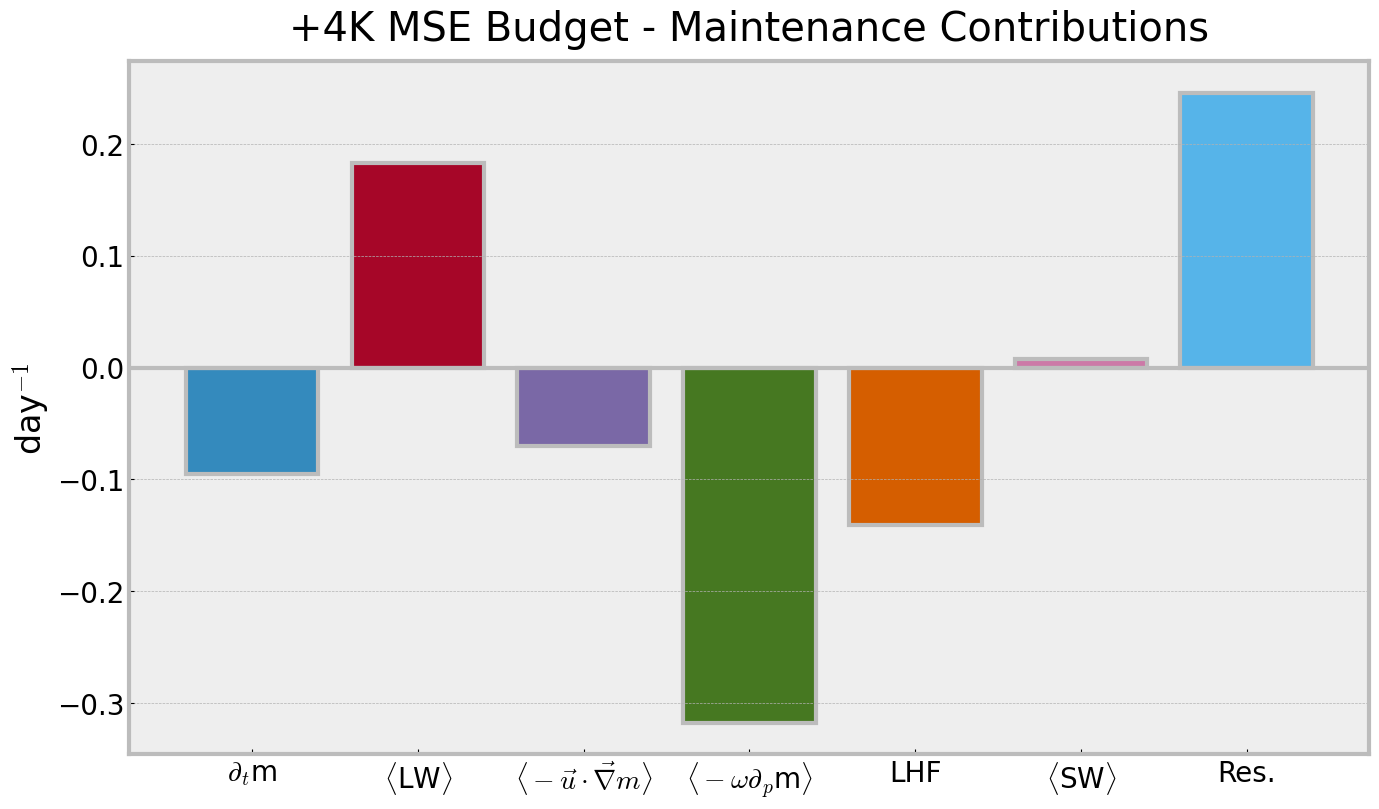

In [93]:
savefig=False

# bars = []
# bar_names = []
# for variable_name, variable_data in budget_maintenance_contribution.data_vars.items():
#     # print(var.name)
#     if variable_name != 'Moist Static Energy':
#         bars.append(24*3600*variable_data)
#         bar_names.append(variable_name)

bars = [
    24*3600*budget_maintenance_contribution['MSE Tendency'],
    24*3600*budget_maintenance_contribution['Longwave Heating'],
    24*3600*(budget_maintenance_contribution['Zonal Advection']+budget_maintenance_contribution['Meridional Advection']),
    24*3600*budget_maintenance_contribution['Vertical Advection'],
    24*3600*budget_maintenance_contribution['Latent Heating'],
    24*3600*budget_maintenance_contribution['Shortwave Heating'],
    24*3600*budget_maintenance_contribution['Residual'],
]

bar_names = [
    r"$\partial_t$m",
    r"$\langle$LW$\rangle$",
    r"$\langle-\vec{u}\cdot\vec{\nabla} m\rangle$",
    r"$\langle-\omega \partial_p$m$\rangle$",
    r"LHF",
    r"$\langle$SW$\rangle$",
    r"Res."
]

plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(1, 1, figsize=(16,9))
ax.set_title(f"{experiment_shortname} MSE Budget - Maintenance Contributions", pad=15)
ax.bar(
    np.arange(len(bars)),
    bars,
    color=[bmh_colors(i+1) for i in range(len(bars))],
    edgecolor='#bcbcbc',
    lw=3
)
# plt.legend(fontsize=12)

ax.set_ylabel(r'day$^{-1}$')
ax.set_xticks(
    np.arange(len(bars)),
    # labels=[
    #     budget_maintenance_contribution[name].attrs['math_name']
    #     for name in budget_maintenance_contribution
    #     if name != 'Moist Static Energy'
    # ],
    labels=bar_names,
    fontsize=20
)
ax.axhline(y=0, color='#bcbcbc', lw=3)
ax.grid(axis='x')

for spine in ax.spines.values():
    spine.set_edgecolor("#bcbcbc")
    spine.set_linewidth(3)

if not savefig:
    plt.show()
else:
    save_string = f"{experiment}_MSE_maintenance-budget.png"
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/Andersen_Kuang_plots/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )
    print("Saved")

# Propagation

## Calculate propagation contribution

In [146]:
str_width = 40
composite_day = 0
zonal_mean_region = slice(0,360)
meridional_mean_region = slice(-6,12)

xr.set_options(keep_attrs=True)
print(f"{'Budget Propagation Contribution':^{str_width}}")
print(f"{'='*str_width}")

# analysis_variables = variables_composited.sel(day=0)
# analysis_variables = variables_mjo_composited
analysis_variables = scaled_budget_variables_regressed
# analysis_variables = variables_mjo_filtered.isel(time=slice(100,110)).mean(dim='time')

budget_propagation_contribution = {}
for index, (variable_name, variable_data) in enumerate(analysis_variables.data_vars.items()):
    print(
        f"{f'({index+1}/{len(analysis_variables)}) {variable_name}...':<{str_width-1}}",
        end=""
    )
    numerator = variable_data*analysis_variables['MSE Tendency']
    denominator = analysis_variables['MSE Tendency']*analysis_variables['MSE Tendency']

    budget_propagation_contribution[variable_name] = (
        numerator.sel(lat=meridional_mean_region).integrate(coord='lat').sel(lon=zonal_mean_region).integrate(coord='lon')
        / denominator.sel(lat=meridional_mean_region).integrate(coord='lat').sel(lon=zonal_mean_region).integrate(coord='lon')
    )
    budget_propagation_contribution[variable_name].name = variable_data.name
    budget_propagation_contribution[variable_name].attrs['math_name'] = variable_data.attrs['math_name']
    print(rf"{'✔':>1}")

budget_propagation_contribution = xr.merge([variable for variable in budget_propagation_contribution.values()])

print(f"{'='*str_width}")
print("Finished")

    Budget Propagation Contribution     
(1/10) Moist Static Energy...          ✔
(2/10) MSE Tendency...                 ✔
(3/10) Zonal Advection...              ✔
(4/10) Meridional Advection...         ✔
(5/10) Vertical Advection...           ✔
(6/10) Longwave Heating...             ✔
(7/10) Shortwave Heating...            ✔
(8/10) Latent Heating...               ✔
(9/10) Sensible Heating...             ✔
(10/10) Residual...                    ✔
Finished


## Plot propagation contribution

Saving plot as -4K_MSE_propagation-budget.png
Saved


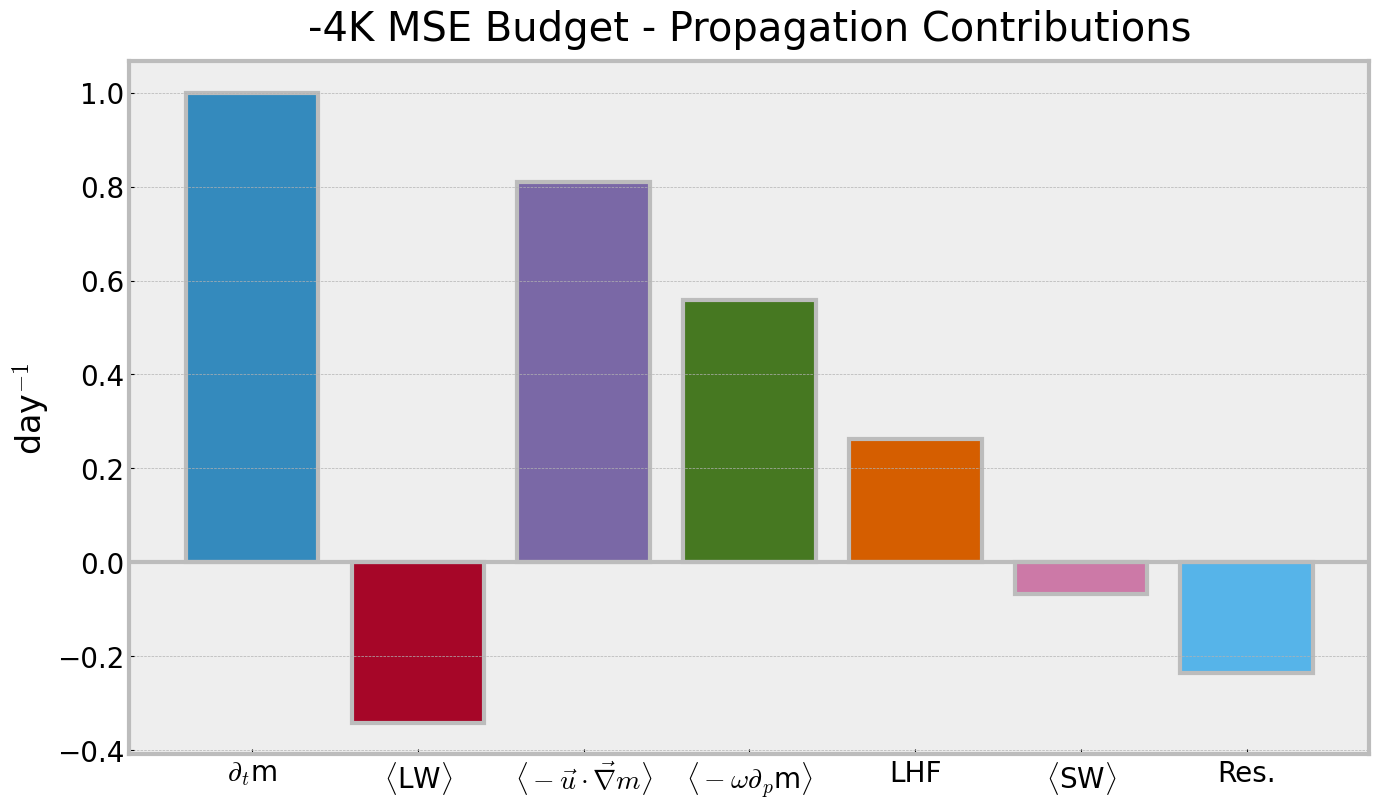

In [147]:
# bars = []
# bar_names = []
# for variable_name, variable_data in budget_propagation_contribution.data_vars.items():
#     # print(var.name)
#     if variable_name != 'Moist Static Energy':
#         bars.append(variable_data)
#         bar_names.append(variable_name)

bars = [
    budget_propagation_contribution['MSE Tendency'],
    budget_propagation_contribution['Longwave Heating'],
    (budget_propagation_contribution['Zonal Advection']+budget_propagation_contribution['Meridional Advection']),
    budget_propagation_contribution['Vertical Advection'],
    budget_propagation_contribution['Latent Heating'],
    budget_propagation_contribution['Shortwave Heating'],
    budget_propagation_contribution['Residual'],
]

bar_names = [
    r"$\partial_t$m",
    r"$\langle$LW$\rangle$",
    r"$\langle-\vec{u}\cdot\vec{\nabla} m\rangle$",
    r"$\langle-\omega \partial_p$m$\rangle$",
    r"LHF",
    r"$\langle$SW$\rangle$",
    r"Res."
]

plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(1, 1, figsize=(16,9))
ax.set_title(f"{experiment_shortname} MSE Budget - Propagation Contributions", pad=15)
ax.bar(
    np.arange(len(bars)),
    bars,
    color=[bmh_colors(i+1) for i in range(len(bars))],
    edgecolor='#bcbcbc',
    lw=3
)
# plt.legend(fontsize=12)

ax.set_ylabel(r'day$^{-1}$')
ax.set_xticks(
    np.arange(len(bars)),
    # labels=[
    #     budget_propagation_contribution[name].attrs['math_name']
    #     for name in budget_propagation_contribution
    #     if name != 'Moist Static Energy'
    # ],
    labels=bar_names,
    fontsize=20
)
ax.axhline(y=0, color='#bcbcbc', lw=3)
ax.grid(axis='x')

for spine in ax.spines.values():
    spine.set_edgecolor("#bcbcbc")
    spine.set_linewidth(3)

if not savefig:
    plt.show()
else:
    save_string = f"{experiment}_MSE_propagation-budget.png"
    print(f"Saving plot as {save_string}")
    plt.savefig(
        f"{output_directory}/Andersen_Kuang_plots/{save_string}",
        dpi=500,
        bbox_inches="tight",
    )
    print("Saved")